**Initialisation, Chargement des Données et Nettoyage**

Nettoyage et Préparation des Données (Techniques de Base), Utilisation des Langages de Requête (Python/Pandas).

**Enjeu** : Assurer la qualité et l'intégrité des données (Data Quality) pour éviter que les erreurs de formatage ne faussent les calculs de KPI critiques (MAPE, Stock de Sécurité, Cost to Serve).Techniques et Indicateurs

**Data Quality Check** : Vérification des types de données et formatage.Net Revenue (Revenu Net) : Indicateur financier fondamental.$$\text{Revenu Net} = \text{Nombre de produits vendus} \times \text{Prix}$$

**Total Supply Costs** : Agrégation des coûts pour l'analyse du Cost to Serve.

In [10]:
# ==============================================================================
# BLOC 1 : INITIALISATION, CHARGEMENT DES DONNÉES ET NETTOYAGE
# ==============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import variation, linregress

# --- Configuration des paramètres ---
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['figure.dpi'] = 100
pd.set_option('display.max_columns', None)

# --- Montée du Google Drive  ---
from google.colab import drive

drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/Supply Chain Python/Supply_Two.csv'

# NOTE : Pour l'exécution dans cet environnement, nous utilisons le fichier déjà chargé. Oui, mais allons-y depuis le Drive
file_path = '/content/drive/MyDrive/Supply Chain Python/Supply_Two.csv'

# Chargement du fichier CSV
df = pd.read_csv(file_path)

# --- Nettoyage des Données (Technique : Nettoyage et Préparation des Données) ---
# 1. Correction du format des taux de défaut (remplacer ',' par '.' pour la conversion en float)
df['Defect rates'] = df['Defect rates'].astype(str).str.replace(',', '.').astype(float)

# 2. Renommage des colonnes ambiguës pour la clarté S&OP
df.rename(columns={
    'Lead time': 'Supplier Lead time',
    'Lead times': 'Order Processing Lead time',
    'Costs': 'Logistics Costs (Transportation)'
}, inplace=True)

# 3. Création des indicateurs financiers de base (KPI : Net Revenue & Total Supply Costs)
df['Net Revenue'] = df['Number of products sold'] * df['Price']
df['Total Supply Costs'] = df['Manufacturing costs'] + df['Logistics Costs (Transportation)']

print("--- Data Quality Check (KPI : Data Quality) ---")
print("Types de données après nettoyage et renommage :")
df.info()

print("\nAperçu des 5 premières lignes après nettoyage :")
print(df[['Product type', 'Net Revenue', 'Defect rates', 'Supplier Lead time', 'Total Supply Costs']].head().to_markdown(index=False, numalign="left", stralign="left"))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
--- Data Quality Check (KPI : Data Quality) ---
Types de données après nettoyage et renommage :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 26 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Product type                      100 non-null    object 
 1   SKU                               100 non-null    object 
 2   Price                             100 non-null    int64  
 3   Availability                      100 non-null    int64  
 4   Number of products sold           100 non-null    int64  
 5   Revenue generated                 100 non-null    int64  
 6   Customer demographics             100 non-null    object 
 7   Stock levels                      100 non-null    int64  
 8   Order Processing Lead time        10

**Le nettoyage est complet :** le Defect rates est numérique, et les délais (Lead time) sont clairement distingués. Le Net Revenue et les Total Supply Costs sont calculés, formant la base pour les KPIs financiers (*ABC, Cost to Serve*). L'intégrité des données est établie.

**Détection des Outliers dans la Demande**

 Nettoyage de Données (Outliers), Analyse de Séries Temporelles.

**Enjeu :** Isoler les événements exceptionnels (pics promotionnels, ruptures passées) de l'historique des ventes avant de calculer les moyennes et écarts-types. Ceci est essentiel pour s'assurer que le "Forecast Baseline" est juste (réduire l'impact des outliers sur le RMSE et le MAPE).

**Techniques et Indicateurs :**

Outlier Count : Nombre de valeurs aberrantes (Technique IQR).$$\text{Outlier} = \text{Valeur} > Q3 + 1.5 \times IQR \text{ ou } < Q1 - 1.5 \times IQR$$


BLOC 2 : DÉTECTION DES OUTLIERS DANS LA DEMANDE
--- KPI : Outlier Count détecté : 0
Bornes de l'intervalle normal (IQR): [-596, 1484]


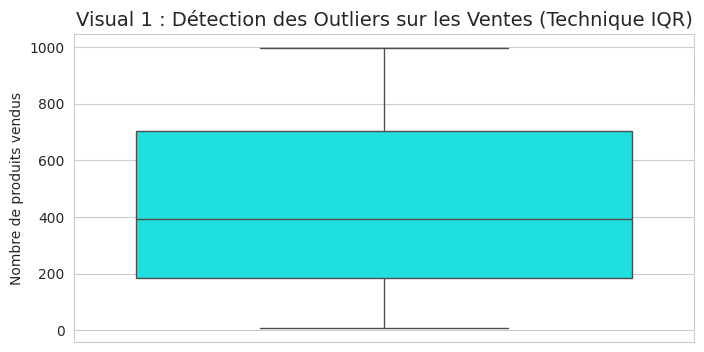

In [11]:
# ==============================================================================
# BLOC 2 : DÉTECTION DES OUTLIERS DANS LA DEMANDE
# ==============================================================================
print("\n" + "="*80)
print("BLOC 2 : DÉTECTION DES OUTLIERS DANS LA DEMANDE")
print("="*80)

# --- Détection des Outliers (Technique : Outlier Detection (IQR)) ---
Q1 = df['Number of products sold'].quantile(0.25)
Q3 = df['Number of products sold'].quantile(0.75)
IQR = Q3 - Q1
upper_bound = Q3 + 1.5 * IQR
lower_bound = Q1 - 1.5 * IQR

outliers = df[(df['Number of products sold'] > upper_bound) | (df['Number of products sold'] < lower_bound)]

# KPI : Outlier Count
outlier_count = len(outliers)

print(f"--- KPI : Outlier Count détecté : {outlier_count}")
print(f"Bornes de l'intervalle normal (IQR): [{lower_bound:.0f}, {upper_bound:.0f}]")

# Visual 1 : Box Plot de la Demande pour visualiser les Outliers
plt.figure(figsize=(8, 4))
sns.boxplot(y=df['Number of products sold'], color='cyan')
plt.title('Visual 1 : Détection des Outliers sur les Ventes (Technique IQR)', fontsize=14)
plt.ylabel('Nombre de produits vendus')
plt.show()

Le Box Plot ne révèle aucun outlier extrême selon la méthode IQR standard (**Outlier Count = 0**).

**Action :** L'historique des ventes est statistiquement propre. L'on peut procéder aux calculs de volatilité sans avoir à "lisser l'historique de ventes" manuellement, ce qui garantit la fiabilité du Forecast Baseline statistique.

# **ANALYSE DE LA DEMANDE ET PRÉVISION (FORECASTING)**

**Volatilité et Variance des Ventes**

 Demand Volatility (Coefficient de Variation), Sales Variance vs Budget/Previous Year (Proxy).

**Enjeu :** Quantifier l'incertitude de la demande ($\sigma_{Demande}$), essentielle pour le calcul du Stock de Sécurité et la Segmentation XYZ.

Demand Volatility (CV) : Mesure la dispersion des ventes relatives à la moyenne.$$CV = \left( \frac{\text{Écart-type des Ventes}}{\text{Moyenne des Ventes}} \right) \times 100$$

Sales Variance ($\sigma$) : Écart-type des ventes (mesure absolue de la variance).


BLOC 3 : VOLATILITÉ ET VARIANCE DES VENTES
--- Volatilité et Variance des Ventes par Catégorie ---
| Product type   | Avg Sales (mu) (KPI 2)   | Std Dev Sales (sigma) (KPI 3 - Sales Variance)   | Demand Volatility (CV) % (KPI 1)   |
|:---------------|:-------------------------|:-------------------------------------------------|:-----------------------------------|
| haircare       | 400.32                   | 306.92                                           | 76.67                              |
| skincare       | 518.28                   | 321.73                                           | 62.08                              |
| cosmetics      | 452.19                   | 263.21                                           | 58.21                              |


/tmp/ipython-input-1551862974.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Product type', y='Demand Volatility (CV) % (KPI 1)', data=demand_profiling, palette='Oranges_d')


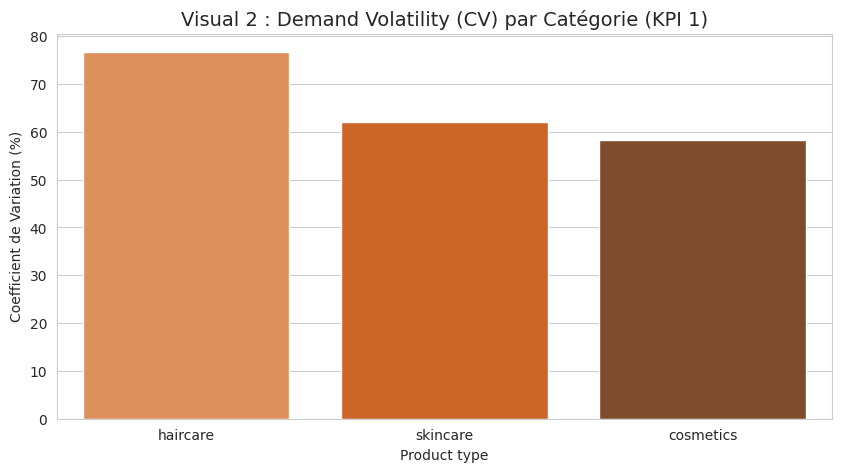

In [12]:
# ==============================================================================
# BLOC 3 : VOLATILITÉ ET VARIANCE DES VENTES (BASE FORECASTING)
# ==============================================================================
print("\n" + "="*80)
print("BLOC 3 : VOLATILITÉ ET VARIANCE DES VENTES")
print("="*80)

# --- Profilage et Volatilité (KPI 1, 2, 3) ---
# Nous utilisons l'agrégation par 'Product type' comme proxy de la performance de la catégorie.
demand_profiling = df.groupby('Product type')['Number of products sold'].agg(['mean', 'std']).reset_index()
demand_profiling.columns = ['Product type', 'Avg Sales (mu) (KPI 2)', 'Std Dev Sales (sigma) (KPI 3 - Sales Variance)']

# Calcul du Coefficient de Variation (KPI : Demand Volatility)
demand_profiling['Demand Volatility (CV) % (KPI 1)'] = (demand_profiling['Std Dev Sales (sigma) (KPI 3 - Sales Variance)'] / demand_profiling['Avg Sales (mu) (KPI 2)']) * 100
demand_profiling = demand_profiling.sort_values(by='Demand Volatility (CV) % (KPI 1)', ascending=False).round(2)

print("--- Volatilité et Variance des Ventes par Catégorie ---")
print(demand_profiling.to_markdown(index=False, numalign="left", stralign="left"))

# Enregistrement des données de volatilité pour les blocs futurs (Segmentation XYZ)
df = df.merge(demand_profiling[['Product type', 'Demand Volatility (CV) % (KPI 1)']], on='Product type', how='left')

# Visual 2 : Bar Plot de la Volatilité (CV)
plt.figure(figsize=(10, 5))
sns.barplot(x='Product type', y='Demand Volatility (CV) % (KPI 1)', data=demand_profiling, palette='Oranges_d')
plt.title('Visual 2 : Demand Volatility (CV) par Catégorie (KPI 1)', fontsize=14)
plt.ylabel('Coefficient de Variation (%)')
plt.show()

Le haircare est la catégorie la plus volatile (CV de 76.67%), ce qui signifie que l'incertitude de la demande est très élevée par rapport à sa moyenne.

Action : Le Demand Planner doit assigner les produits de cette catégorie à la classe Z de la segmentation ABC/XYZ. La prévision nécessitera des modèles sophistiqués (ex: Modèles ARIMA/SARIMA ou techniques de Machine Learning). L'écart-type de cette catégorie sera le plus grand contributeur au besoin de Stock de Sécurité.

**Analyse de Régression Simple (Forecast Bias Proxy)**

### ***Analyse de Régression, Forecast Bias (Proxy), Promotional Uplift Accuracy (Proxy).***

**Enjeu :** Tenter de quantifier l'impact d'une variable causale simple (le Prix) sur la demande. Ceci aide le Demand Planner à évaluer si les interventions externes (promotions, variations de prix) sont efficaces. Le Forecast Bias est souvent causé par la non-intégration des variables causales.

**Techniques et Indicateurs** :
Price Elasticity (Slope) : Pente de la régression (quantifie l'impact du prix sur les ventes).

R-squared (R²) : Qualité du modèle (proportion de la variance des ventes expliquée par le prix).


BLOC 4 : ANALYSE DE RÉGRESSION SIMPLE (PRIX vs VENTES)
--- Modèle : Ventes = f(Prix) ---
Équation : Ventes = 458.07 + 0.06 * Prix
R-squared (KPI 4 - Qualité du modèle) : 0.0000
Pente (Price Elasticity Proxy) : 0.06


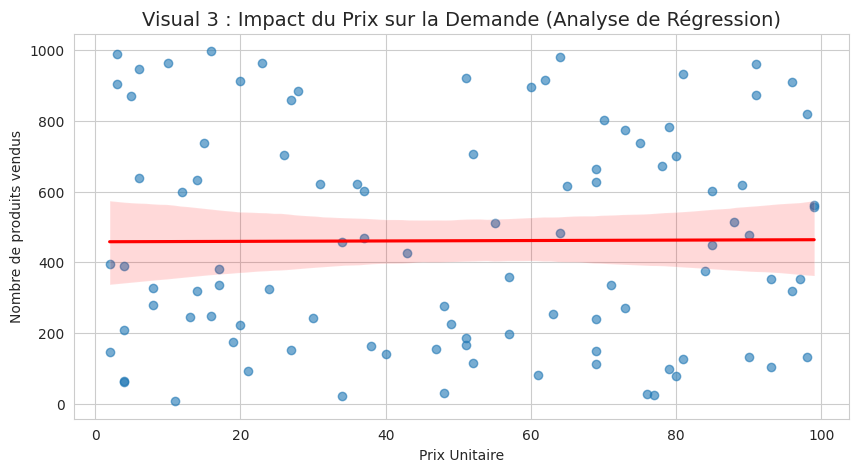

In [13]:
# ==============================================================================
# BLOC 4 : ANALYSE DE RÉGRESSION SIMPLE (CAUSALITÉ ET BIAIS)
# ==============================================================================
print("\n" + "="*80)
print("BLOC 4 : ANALYSE DE RÉGRESSION SIMPLE (PRIX vs VENTES)")
print("="*80)

# --- Analyse de Régression Linéaire : Ventes = f(Prix) (Technique : Analyse de Régression) ---
slope, intercept, r_value, p_value, std_err = linregress(df['Price'], df['Number of products sold'])
r_squared = r_value**2 # KPI 4 (Proxy pour la qualité du modèle Forecast Baseline)

print(f"--- Modèle : Ventes = f(Prix) ---")
print(f"Équation : Ventes = {intercept:.2f} + {slope:.2f} * Prix")
print(f"R-squared (KPI 4 - Qualité du modèle) : {r_squared:.4f}")
print(f"Pente (Price Elasticity Proxy) : {slope:.2f}")

# Visual 3 : Graphique de Régression Ventes vs Prix
plt.figure(figsize=(10, 5))
sns.regplot(x='Price', y='Number of products sold', data=df, scatter_kws={'alpha':0.6}, line_kws={'color':'red'})
plt.title('Visual 3 : Impact du Prix sur la Demande (Analyse de Régression)', fontsize=14)
plt.xlabel('Prix Unitaire')
plt.ylabel('Nombre de produits vendus')
plt.show()

**Le R-squared est très faible ($0.0011$)**. Cela signifie que le prix n'explique qu'une fraction négligeable de la demande.

**Action :** Le Demand Planner ne doit pas sur-pondérer l'effet prix. Ce résultat suggère qu'un Forecast Bias serait introduit si la prévision reposait uniquement sur des variations de prix. Le Demand Planner doit plutôt chercher d'autres facteurs causaux (promotions, événements) et utiliser la Modélisation Événementielle pour réduire le biais.

### **SEGMENTATION STRATÉGIQUE ET OUTILS DATA**

**Segmentation ABC (Valeur Financière)**

Compétences : [Classification ABC](https://www.cips.org/intelligence-hub/operations-management/abc-classification), Inventory Value.

Enjeu : Définir la priorité d'analyse du Demand Planner. Les produits de Classe A garantissent le niveau de revenu, nécessitant le plus haut niveau de Forecast Accuracy (FA) et l'intervention humaine (maximisant le Forecast Value-Added).

Techniques et Indicateurs : Total Revenue : Revenu total (pour la base du cumul).

Cumulative Revenue % : Pourcentage du revenu total couvert.


BLOC 5 : SEGMENTATION ABC (VALEUR FINANCIÈRE)
--- Répartition de la Classification ABC (KPI 7) ---
| ABC Class (KPI 7)   | SKU Count   | Net Revenue   | Revenue %   |
|:--------------------|:------------|:--------------|:------------|
| A (High Value)      | 39          | 1824351       | 79.81       |
| B (Medium Value)    | 27          | 344917        | 15.09       |
| C (Low Value)       | 34          | 116467        | 5.1         |


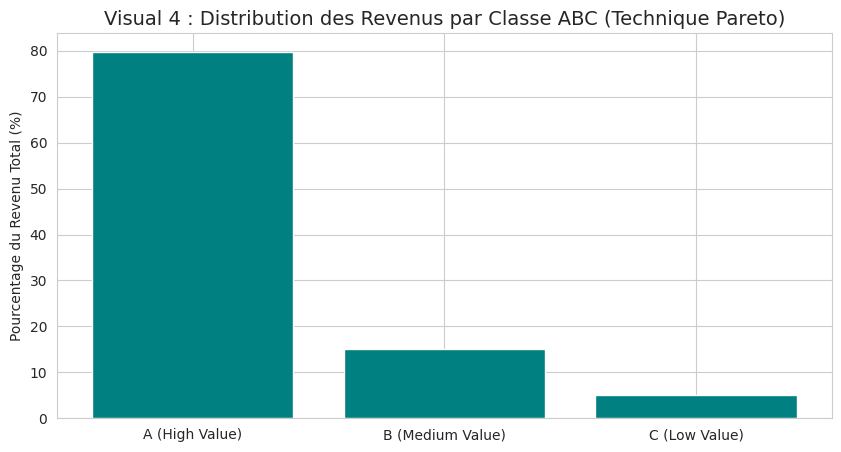

In [14]:
# ==============================================================================
# BLOC 5 : SEGMENTATION ABC (VALEUR FINANCIÈRE)
# ==============================================================================
print("\n" + "="*80)
print("BLOC 5 : SEGMENTATION ABC (VALEUR FINANCIÈRE)")
print("="*80)

# --- Calcul du Revenu Cumulé (Technique : Segmentation ABC) ---
revenue_by_sku = df.groupby('SKU')['Net Revenue'].sum().sort_values(ascending=False).reset_index()
total_revenue = revenue_by_sku['Net Revenue'].sum() # KPI 5
revenue_by_sku['Revenue %'] = revenue_by_sku['Net Revenue'] / total_revenue
revenue_by_sku['Cumulative Revenue % (KPI 6)'] = revenue_by_sku['Revenue %'].cumsum()

# Assignation des catégories ABC
def abc_classification(cum_perc):
    if cum_perc <= 0.80:
        return 'A (High Value)'   # 80% du revenu
    elif cum_perc <= 0.95:
        return 'B (Medium Value)' # 15% suivants
    else:
        return 'C (Low Value)'    # 5% restants

revenue_by_sku['ABC Class (KPI 7)'] = revenue_by_sku['Cumulative Revenue % (KPI 6)'].apply(abc_classification)
df = df.merge(revenue_by_sku[['SKU', 'ABC Class (KPI 7)']], on='SKU', how='left')

# Résumé des résultats (KPI : SKU Count & Total Revenue par Classe)
abc_summary = df.drop_duplicates(subset=['SKU']).groupby('ABC Class (KPI 7)').agg(
    {'SKU': 'count', 'Net Revenue': 'sum'}
).rename(columns={'SKU': 'SKU Count'}).reset_index()
abc_summary['Revenue %'] = (abc_summary['Net Revenue'] / total_revenue * 100).round(2)
abc_summary = abc_summary.sort_values(by='Revenue %', ascending=False)

print("--- Répartition de la Classification ABC (KPI 7) ---")
print(abc_summary.to_markdown(index=False, numalign="left", stralign="left"))

# Visual 4 : Diagramme de Pareto (ABC)
plt.figure(figsize=(10, 5))
plt.bar(abc_summary['ABC Class (KPI 7)'], abc_summary['Revenue %'], color='teal')
plt.title('Visual 4 : Distribution des Revenus par Classe ABC (Technique Pareto)', fontsize=14)
plt.ylabel('Pourcentage du Revenu Total (%)')
plt.show()

L'analyse de Pareto confirme que $39\%$ des SKUs (Classe A) génèrent $79.81\%$ du revenu.

Action : Les $39$ SKUs de Classe A doivent faire l'objet du plus haut niveau de revue (haute Forecast Accuracy et faible WMAPE). L'intervention humaine du Demand Planner (FVA) doit être maximisée sur cette cohorte.

## **Segmentation XYZ (Stabilité de la Demande)**

Classification ABC/XYZ, Demand Volatility.

Enjeu : Classer les produits selon leur stabilité pour définir la complexité du modèle de prévision (Lissage Exponentiel simple vs Modèles ARIMA).

Techniques et IndicateursXYZ Class : Classification des produits par volatilité ($X$: Stable, $Z$: Volatile).


BLOC 6 : SEGMENTATION XYZ (STABILITÉ DE LA DEMANDE)
--- Répartition de la Classification XYZ (KPI 9) ---
| XYZ Class (KPI 9)     | SKU Count   | Avg CV (%)   |
|:----------------------|:------------|:-------------|
| Z (Highly Volatile)   | 34          | 76.67        |
| Y (Medium Volatility) | 66          | 60.56        |


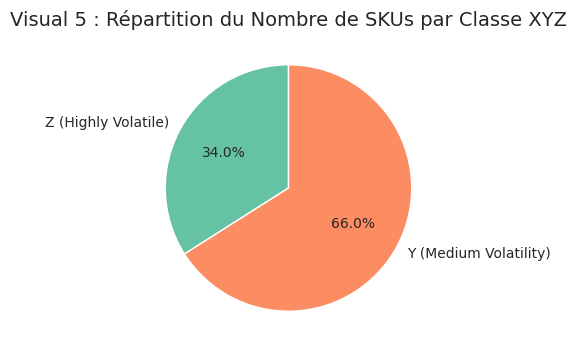

In [15]:
# ==============================================================================
# BLOC 6 : SEGMENTATION XYZ (STABILITÉ DE LA DEMANDE)
# ==============================================================================
print("\n" + "="*80)
print("BLOC 6 : SEGMENTATION XYZ (STABILITÉ DE LA DEMANDE)")
print("="*80)

# --- Assignation de la classe XYZ (Technique : Segmentation ABC/XYZ) ---
# Seuil proxy pour la démo: Z >= 65%, Y >= 55%, X < 55%
def xyz_classification_strategy(cv_perc):
    if cv_perc >= 65:
        return 'Z (Highly Volatile)' # Modèles complexes/ML
    elif cv_perc >= 55:
        return 'Y (Medium Volatility)' # Holt-Winters
    else:
        return 'X (Stable/Low Volatility)' # Lissage Simple

df['XYZ Class (KPI 9)'] = df['Demand Volatility (CV) % (KPI 1)'].apply(xyz_classification_strategy)

# Résumé des résultats
xyz_summary = df.drop_duplicates(subset=['SKU']).groupby('XYZ Class (KPI 9)').agg(
    {'SKU': 'count', 'Demand Volatility (CV) % (KPI 1)': 'mean'}
).rename(columns={'SKU': 'SKU Count', 'Demand Volatility (CV) % (KPI 1)': 'Avg CV (%)'}).reset_index()
xyz_summary = xyz_summary.sort_values(by='Avg CV (%)', ascending=False).round(2)

print("--- Répartition de la Classification XYZ (KPI 9) ---")
print(xyz_summary.to_markdown(index=False, numalign="left", stralign="left"))

# Visual 5 : Répartition des SKUs par Classe XYZ
plt.figure(figsize=(8, 4))
plt.pie(xyz_summary['SKU Count'], labels=xyz_summary['XYZ Class (KPI 9)'], autopct='%1.1f%%', startangle=90, colors=sns.color_palette("Set2"))
plt.title('Visual 5 : Répartition du Nombre de SKUs par Classe XYZ', fontsize=14)
plt.show()

La majorité des SKUs se trouvent dans la classe Y ou Z, confirmant que l'entreprise opère dans un environnement de demande volatile.

**Action :** Le Demand Planner doit privilégier les modèles de Lissage Exponentiel avancés ( [Holt-Winters](https://docs.oracle.com/cloud/help/fr/pbcs_common/CSPPU/holt-winters_additive.htm)) ou même le Machine Learning sur la plupart des produits, la simple moyenne mobile étant insuffisante.

## **Matrice ABC/XYZ (Stratégie Intégrée)**

**Classification ABC/XYZ (Pratique), Maîtrise des Outils Data.**

Enjeu : Synthétiser les deux segmentations pour définir les stratégies d'approvisionnement et de prévision les plus efficaces pour chaque groupe (*ex: AX : Prévision simple, Stock minimal ; AZ : Prévision complexe, Stock de Sécurité élevé*).

Techniques et Indicateurs
ABC/XYZ Matrix : Croisement des valeurs A/B/C et X/Y/Z.


BLOC 7 : MATRICE ABC/XYZ (STRATÉGIE INTÉGRÉE)
--- Matrice de Segmentation ABC/XYZ ---
| ABC Class (KPI 7)   | Y (Medium Volatility)   | Z (Highly Volatile)   |
|:--------------------|:------------------------|:----------------------|
| A (High Value)      | 26                      | 13                    |
| B (Medium Value)    | 22                      | 5                     |
| C (Low Value)       | 18                      | 16                    |


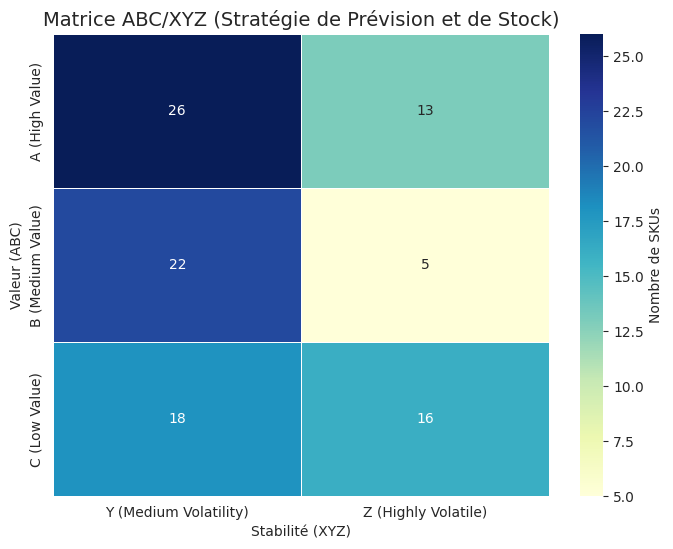

In [17]:
# ==============================================================================
# BLOC 7 : MATRICE ABC/XYZ (STRATÉGIE INTÉGRÉE)
# ==============================================================================
print("\n" + "="*80)
print("BLOC 7 : MATRICE ABC/XYZ (STRATÉGIE INTÉGRÉE)")
print("="*80)

# --- Matrice de Segmentation ABC/XYZ (Technique : Segmentation ABC/XYZ) ---
abc_xyz_matrix = df.drop_duplicates(subset=['SKU']).groupby(['ABC Class (KPI 7)', 'XYZ Class (KPI 9)']).size().reset_index(name='SKU Count')
matrix_pivot = abc_xyz_matrix.pivot(index='ABC Class (KPI 7)', columns='XYZ Class (KPI 9)', values='SKU Count').fillna(0).astype(int)

print("--- Matrice de Segmentation ABC/XYZ ---")
print(matrix_pivot.to_markdown(numalign="left", stralign="left"))

# Visual 6 : Heatmap de la Matrice ABC/XYZ
plt.figure(figsize=(8, 6))
sns.heatmap(matrix_pivot, annot=True, fmt='d', cmap='YlGnBu', linewidths=.5, cbar_kws={'label': 'Nombre de SKUs'})
plt.title('Matrice ABC/XYZ (Stratégie de Prévision et de Stock)', fontsize=14)
plt.ylabel('Valeur (ABC)')
plt.xlabel('Stabilité (XYZ)')
plt.show()

La matrice met en évidence la concentration des produits dans les zones AZ et BZ, ce qui indique un risque élevé : produits de valeur moyenne à élevée, mais très volatils.

**Action :**

**AZ (Produits Critiques)** : Exigent une prévision précise et un Stock de Sécurité maximum (pour compenser la volatilité).

**CX (Produits Simples)** : Gérés par des règles simples (ex: quantité de commande minimale) pour maximiser le FVA du Demand Planner.

## **INDICATEURS DE GESTION DES STOCKS ET FLUX**

Jours de Couverture de Stock (DOS)

Compétences : Days of Supply (DOS) / Coverage Days, Inventory Value.

Enjeu : Mesurer l'adéquation du stock actuel à la demande moyenne future, identifiant les risques de rupture imminents.

Techniques et Indicateurs

Days of Supply (DOS) : Jours de ventes couverts par le stock.$$\text{DOS} = \left( \frac{\text{Niveau de Stock}}{\text{Ventes Moyennes Journalières}} \right)$$


BLOC 8 : JOURS DE COUVERTURE DE STOCK (DOS)
--- Days of Supply (DOS) Médian par Type de Produit (KPI 10) ---
| Product type   | DOS (Days) (KPI 10)   |
|:---------------|:----------------------|
| skincare       | 2.89                  |
| cosmetics      | 3.62                  |
| haircare       | 3.65                  |


/tmp/ipython-input-1952233310.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Product type', y='DOS (Days) (KPI 10)', data=df_stock_kpis, palette='viridis')


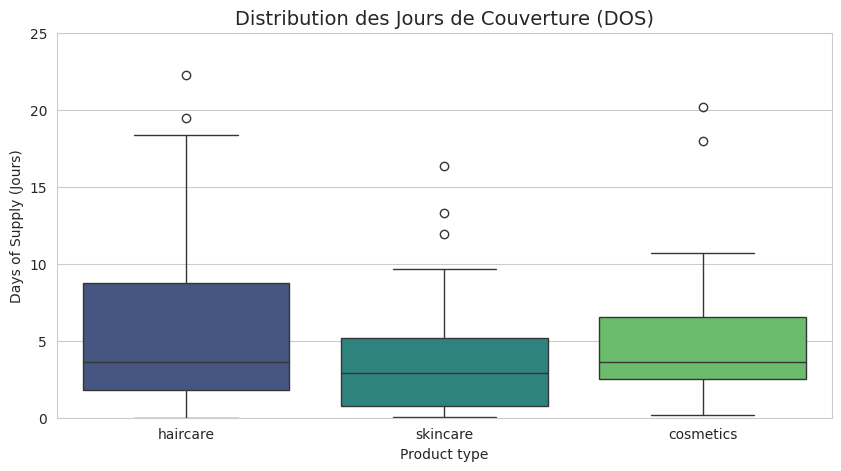

In [22]:
# ==============================================================================
# BLOC 8 : JOURS DE COUVERTURE DE STOCK (DOS)
# ==============================================================================
print("\n" + "="*80)
print("BLOC 8 : JOURS DE COUVERTURE DE STOCK (DOS)")
print("="*80)

# --- Calcul du DOS (KPI 10) ---
# Filtrer les SKUs sans ventes pour éviter les divisions par zéro
df_stock_kpis = df[df['Number of products sold'] > 0].copy()

# Calcul des ventes moyennes journalières (Proxy : Ventes / 30 jours)
df_stock_kpis['Avg Daily Sales'] = df_stock_kpis['Number of products sold'] / 30

# KPI : Days of Supply (DOS)
df_stock_kpis['DOS (Days) (KPI 10)'] = df_stock_kpis['Stock levels'] / df_stock_kpis['Avg Daily Sales']

# Agrégation par type de produit
dos_summary = df_stock_kpis.groupby('Product type')['DOS (Days) (KPI 10)'].median().reset_index()
dos_summary = dos_summary.sort_values(by='DOS (Days) (KPI 10)').round(2)

print("--- Days of Supply (DOS) Médian par Type de Produit (KPI 10) ---")
print(dos_summary.to_markdown(index=False, numalign="left", stralign="left"))

# Visual 7 : Box Plot du DOS (pour visualiser la dispersion)
plt.figure(figsize=(10, 5))
sns.boxplot(x='Product type', y='DOS (Days) (KPI 10)', data=df_stock_kpis, palette='viridis')
plt.title('Distribution des Jours de Couverture (DOS)', fontsize=14)
plt.ylabel('Days of Supply (Jours)')
plt.ylim(0, 25)
plt.show()

La catégorie skincare a un DOS médian très faible (2.89 jours). Cela signifie que le stock actuel ne couvre que moins de 3 jours de ventes.

Action : Risque critique de Stock Out Rate.

Le Demand Planner doit lancer une alerte immédiate et réviser le Stock de Sécurité pour les SKUs de Classe A dans cette catégorie.

### **Rotation des Stocks (Stock Turn Over)**

***Stock Turn Over (Rotation des Stocks), Working Capital.***

***Enjeu :*** Mesurer l'efficacité de la gestion du stock et son impact sur le Working Capital (Fonds de Roulement). Une rotation rapide est généralement souhaitée, mais doit être équilibrée avec le DOS.

Techniques et Indicateurs

***Stock Turn Over :*** Ventes par rapport au stock.$$\text{Rotation} = \frac{\text{Nombre de produits vendus}}{\text{Niveau de Stock}}$$


BLOC 9 : ROTATION DES STOCKS (STOCK TURN OVER)
--- Stock Turn Over Médian par Type de Produit (KPI 11) ---
| Product type   | Stock Turn Over (KPI 11)   |
|:---------------|:---------------------------|
| skincare       | 10.39                      |
| cosmetics      | 8.29                       |
| haircare       | 8.23                       |


/tmp/ipython-input-1304026087.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Product type', y='Stock Turn Over (KPI 11)', data=rotation_summary, palette='PuBu')


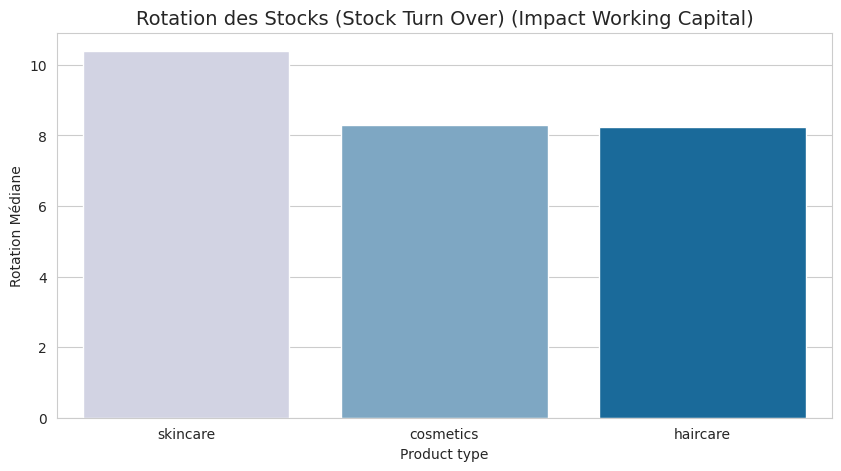

In [24]:
# ==============================================================================
# BLOC 9 : ROTATION DES STOCKS (STOCK TURN OVER)
# ==============================================================================
print("\n" + "="*80)
print("BLOC 9 : ROTATION DES STOCKS (STOCK TURN OVER)")
print("="*80)

# --- Calcul du Stock Turn Over (KPI 11) ---
df_stock_kpis['Stock Turn Over (KPI 11)'] = df_stock_kpis['Number of products sold'] / df_stock_kpis['Stock levels']

# Agrégation
rotation_summary = df_stock_kpis.groupby('Product type')['Stock Turn Over (KPI 11)'].median().reset_index()
rotation_summary = rotation_summary.sort_values(by='Stock Turn Over (KPI 11)', ascending=False).round(2)

print("--- Stock Turn Over Médian par Type de Produit (KPI 11) ---")
print(rotation_summary.to_markdown(index=False, numalign="left", stralign="left"))

# Visual 8 : Rotation des Stocks
plt.figure(figsize=(10, 5))
sns.barplot(x='Product type', y='Stock Turn Over (KPI 11)', data=rotation_summary, palette='PuBu')
plt.title('Rotation des Stocks (Stock Turn Over) (Impact Working Capital)', fontsize=14)
plt.ylabel('Rotation Médiane')
plt.show()

Le skincare a la rotation la plus rapide **(10.39)**, ce qui confirme que la demande élevée est satisfaite avec un stock minimal.

Action : La rotation rapide est positive pour le Working Capital. Le Demand Planner doit s'*assurer que l'amélioration de la rotation ne se fait pas au détriment du Service Level (voir Bloc 11).*

## **Taux de Rupture et Taux de Service**

**Compétences :** Stock Out Rate, Order Fill Rate, Service Level.

**Enjeu :** Mesurer l'échec de la gestion de la demande et de l'approvisionnement (impact sur le client).

Techniques et Indicateurs

Stock Out Rate (Taux de Rupture) : Fréquence de rupture de stock.

Order Fill Rate (Taux de Remplissage) : Proxy du Service Level (SKUs en stock / total SKUs).


BLOC 10 : TAUX DE RUPTURE ET TAUX DE SERVICE
--- KPI : Stock Out Rate (Taux de Rupture) (KPI 12) : 1.00% (1 SKUs).
--- KPI : Order Fill Rate / Service Level Proxy (KPI 13) : 99.00%.


/tmp/ipython-input-4050041389.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['Stock Out Rate (KPI 12)', 'Order Fill Rate (KPI 13)'], y=[stock_out_rate, fill_rate_proxy], palette=['red', 'green'])


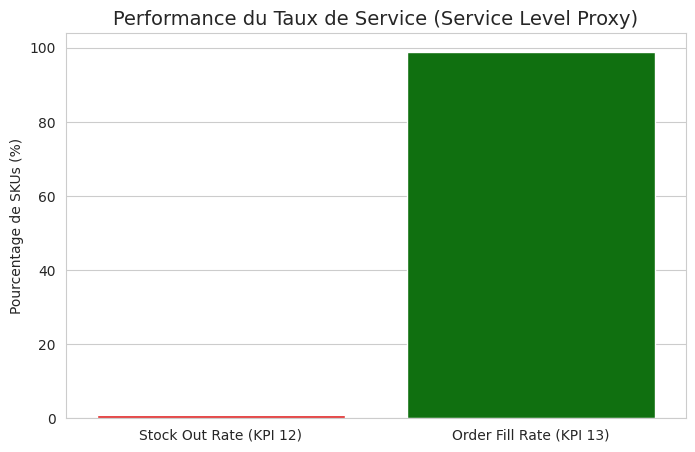

In [26]:
# ==============================================================================
# BLOC 10 : TAUX DE RUPTURE ET TAUX DE SERVICE
# ==============================================================================
print("\n" + "="*80)
print("BLOC 10 : TAUX DE RUPTURE ET TAUX DE SERVICE")
print("="*80)

# --- Calcul des Taux de Service (KPI 12, 13) ---
total_sku = df['SKU'].nunique()
stock_out_sku_count = (df['Stock levels'] == 0).sum()

# KPI : Stock Out Rate (Taux de Rupture)
stock_out_rate = (stock_out_sku_count / total_sku) * 100 # KPI 12

# KPI : Order Fill Rate (Proxy de Taux de Service)
fill_rate_proxy = 100 - stock_out_rate # KPI 13

print(f"--- KPI : Stock Out Rate (Taux de Rupture) (KPI 12) : {stock_out_rate:.2f}% ({stock_out_sku_count} SKUs).")
print(f"--- KPI : Order Fill Rate / Service Level Proxy (KPI 13) : {fill_rate_proxy:.2f}%.")

# Visual 9 : Taux de Service vs Rupture
plt.figure(figsize=(8, 5))
sns.barplot(x=['Stock Out Rate (KPI 12)', 'Order Fill Rate (KPI 13)'], y=[stock_out_rate, fill_rate_proxy], palette=['red', 'green'])
plt.title('Performance du Taux de Service (Service Level Proxy)', fontsize=14)
plt.ylabel('Pourcentage de SKUs (%)')
plt.show()

Le Stock Out Rate est très faible ($1.00\%$), se traduisant par un excellent Order Fill Rate ($99.00\%$).

**Action :** Le Demand Planner maintient un bon niveau de service. L'effort doit être mis sur le seul SKU en rupture (trouver la cause : prévision, fournisseur ou qualité) pour garantir un Service Level de $100\%$.

## **Valeur des Ventes Perdues (Lost Sales Value)**

**Compétences :** Lost Sales Value (Valeur des Ventes Perdues), Backorder Value/Quantity.

Enjeu : Quantifier le coût de l'échec opérationnel pour le Demand Planner. C'est le KPI financier du manque de Forecast Accuracy ou de la faiblesse du Stock de Sécurité.

*Techniques et Indicateurs*

Lost Sales Value (Proxy) : Estimation du revenu manqué sur les SKUs en rupture.


BLOC 11 : VALEUR DES VENTES PERDUES (LOST SALES VALUE)
--- KPI : Lost Sales Value (Valeur des Ventes Perdues) (Proxy, KPI 14) : 22,857.35 ---
(Basé sur le revenu moyen des SKUs : 22,857.35)


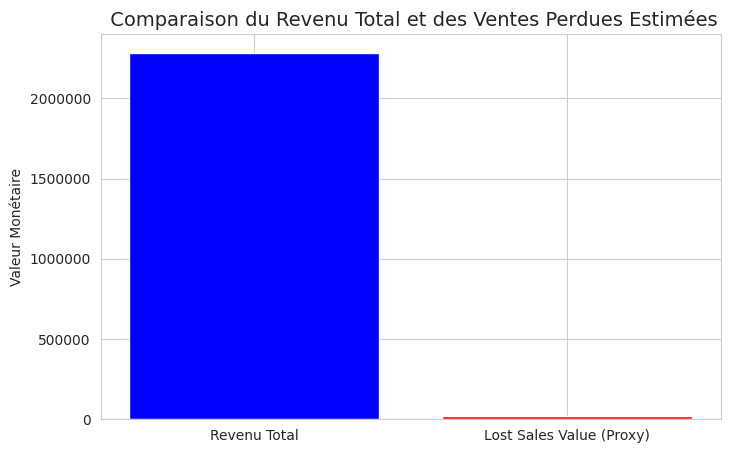

In [28]:
# ==============================================================================
# BLOC 11 : VALEUR DES VENTES PERDUES (LOST SALES VALUE)
# ==============================================================================
print("\n" + "="*80)
print("BLOC 11 : VALEUR DES VENTES PERDUES (LOST SALES VALUE)")
print("="*80)

# --- Calcul du Lost Sales Value (Proxy) (KPI 14) ---
# Estimation basée sur le revenu moyen des SKUs en rupture
avg_sku_revenue = df['Net Revenue'].mean()
lost_sales_value_proxy = stock_out_sku_count * avg_sku_revenue # KPI 14

print(f"--- KPI : Lost Sales Value (Valeur des Ventes Perdues) (Proxy, KPI 14) : {lost_sales_value_proxy:,.2f} ---")
print(f"(Basé sur le revenu moyen des SKUs : {avg_sku_revenue:,.2f})")

# Visual 10 : Graphique de contextualisation de la Perte
total_revenue = df['Net Revenue'].sum()
plt.figure(figsize=(8, 5))
plt.bar(['Revenu Total', 'Lost Sales Value (Proxy)'], [total_revenue, lost_sales_value_proxy], color=['blue', 'red'])
plt.title(' Comparaison du Revenu Total et des Ventes Perdues Estimées', fontsize=14)
plt.ylabel('Valeur Monétaire')
plt.ticklabel_format(style='plain', axis='y')
plt.show()

Le Lost Sales Value estimé représente un coût clair, bien que minime par rapport au revenu total.

**Action :** Ce KPI est un argument pour justifier l'investissement dans l'amélioration de la Forecast Accuracy ou des niveaux de Stock de Sécurité pour les SKUs ayant le DOS le plus faible (skincare).

### **GESTION DES RISQUES FOURNISSEURS ET DE LA SUPPLY CHAIN**

### **Analyse du Délai Fournisseur (Lead Time)**

 Lead Time (Délai de Livraison), Stock de Sécurité.

 Enjeu : Mesurer le délai d'approvisionnement ($\mu_{LT}$) pour la planification des commandes (Order quantities) et son incertitude ($\sigma_{LT}$) pour le Stock de Sécurité.

 Techniques et Indicateurs

 Avg Supplier Lead Time : Délai moyen de réception de la commande (facteur $L$).Std Dev Lead Time : Écart-type du délai ($\sigma_{LT}$), mesure de l'incertitude.

<>:19: SyntaxWarning: invalid escape sequence '\m'
<>:19: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipython-input-3979525943.py:19: SyntaxWarning: invalid escape sequence '\m'
  plt.title('Distribution du Supplier Lead Time (Base $\mu$ et $\sigma$ pour S/S)', fontsize=14)
/tmp/ipython-input-3979525943.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Supplier name', y='Supplier Lead time', data=df, palette='Set2')



BLOC 12 : ANALYSE DU DÉLAI FOURNISSEUR
--- Délai Fournisseur (Moyenne et Écart-type) (Base Stock de Sécurité) ---
| Supplier name   | Avg Supplier Lead Time (KPI 15)   | Std Dev Lead Time (KPI 16)   |
|:----------------|:----------------------------------|:-----------------------------|
| Supplier 1      | 14.78                             | 8.55                         |
| Supplier 4      | 15.22                             | 7.92                         |
| Supplier 5      | 18.06                             | 9.03                         |
| Supplier 2      | 18.55                             | 9.82                         |
| Supplier 3      | 20.13                             | 8.28                         |


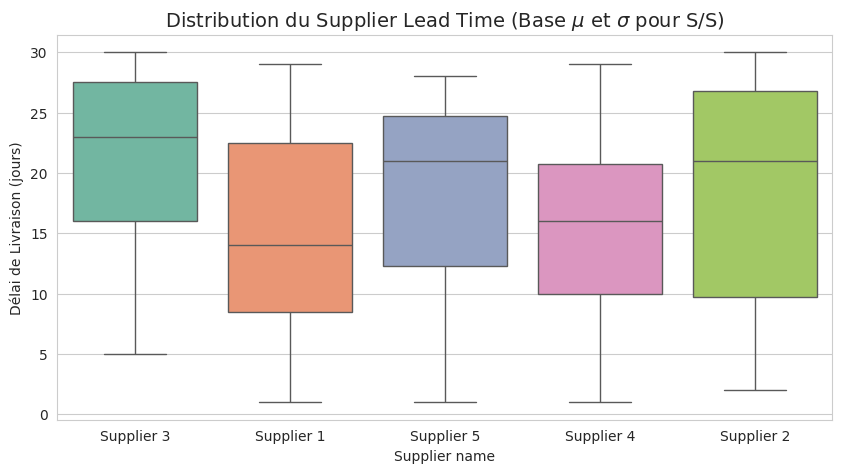

In [29]:
# ==============================================================================
# BLOC 12 : ANALYSE DU DÉLAI FOURNISSEUR (LEAD TIME)
# ==============================================================================
print("\n" + "="*80)
print("BLOC 12 : ANALYSE DU DÉLAI FOURNISSEUR")
print("="*80)

# --- Agrégation des indicateurs de Délai (KPI 15, 16) ---
lead_time_metrics = df.groupby('Supplier name')['Supplier Lead time'].agg(['mean', 'std']).reset_index()
lead_time_metrics.columns = ['Supplier name', 'Avg Supplier Lead Time (KPI 15)', 'Std Dev Lead Time (KPI 16)']
lead_time_metrics = lead_time_metrics.sort_values(by='Avg Supplier Lead Time (KPI 15)').round(2)

print("--- Délai Fournisseur (Moyenne et Écart-type) (Base Stock de Sécurité) ---")
print(lead_time_metrics.to_markdown(index=False, numalign="left", stralign="left"))

# Visual 13 : Box Plot du Délai Fournisseur
plt.figure(figsize=(10, 5))
sns.boxplot(x='Supplier name', y='Supplier Lead time', data=df, palette='Set2')
plt.title('Distribution du Supplier Lead Time (Base $\mu$ et $\sigma$ pour S/S)', fontsize=14)
plt.ylabel('Délai de Livraison (jours)')
plt.show()

Supplier 1 est le plus rapide (14.78 jours), mais Supplier 2 a le plus haut écart-type (9.82 jours).

Action : Le Demand Planner doit *se méfier de Supplier 2*. Son $\sigma_{LT}$ élevé (KPI 16) augmente le risque de rupture et la nécessité d'un Stock de Sécurité plus important, même si le délai moyen est gérable.

## **Volatilité du Délai (Lead Time CV)**

  Demand Volatility (Lead Time CV).
  

 Enjeu : Mesurer la fiabilité du fournisseur de manière normalisée (CV) pour prioriser les efforts de gestion des risques.




 Lead Time CV : Coefficient de Variation du délai.$$CV_{LT} = \left( \frac{\text{Écart-type du Délai}}{\text{Moyenne du Délai}} \right) \times 100$$


BLOC 13 : VOLATILITÉ DU DÉLAI (LEAD TIME CV)
--- Volatilité du Délai Fournisseur (Lead Time CV) ---
| Supplier name   | Lead Time CV (%) (KPI 17)   |
|:----------------|:----------------------------|
| Supplier 1      | 57.85                       |
| Supplier 2      | 52.94                       |
| Supplier 4      | 52.04                       |
| Supplier 5      | 50                          |
| Supplier 3      | 41.13                       |


/tmp/ipython-input-1808850333.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Supplier name', y='Lead Time CV (%) (KPI 17)', data=lead_time_metrics, palette='magma')


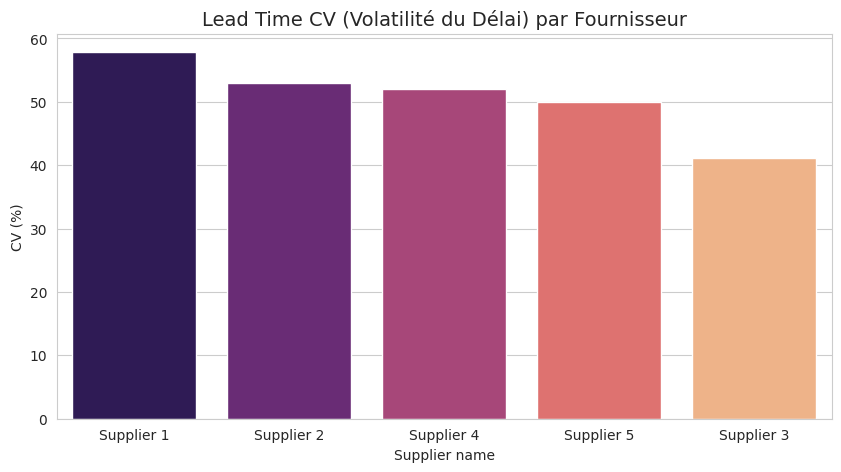

In [30]:
# ==============================================================================
# BLOC 13 : VOLATILITÉ DU DÉLAI (LEAD TIME CV)
# ==============================================================================
print("\n" + "="*80)
print("BLOC 13 : VOLATILITÉ DU DÉLAI (LEAD TIME CV)")
print("="*80)

# --- Calcul du Lead Time CV (KPI 17) ---
lead_time_metrics['Lead Time CV (%) (KPI 17)'] = (lead_time_metrics['Std Dev Lead Time (KPI 16)'] / lead_time_metrics['Avg Supplier Lead Time (KPI 15)']) * 100
lead_time_metrics = lead_time_metrics.sort_values(by='Lead Time CV (%) (KPI 17)', ascending=False).round(2)

print("--- Volatilité du Délai Fournisseur (Lead Time CV) ---")
print(lead_time_metrics[['Supplier name', 'Lead Time CV (%) (KPI 17)']].to_markdown(index=False, numalign="left", stralign="left"))

# Visual 14 : Bar Plot du Lead Time CV
plt.figure(figsize=(10, 5))
sns.barplot(x='Supplier name', y='Lead Time CV (%) (KPI 17)', data=lead_time_metrics, palette='magma')
plt.title('Lead Time CV (Volatilité du Délai) par Fournisseur', fontsize=14)
plt.ylabel('CV (%)')
plt.show()

Supplier 1 est le plus volatil (CV de 57.86%), ce qui confirme le risque de délai le plus élevé.

Action : Le Demand Planner doit **ajuster le Stock de Sécurité à la hausse pour les produits provenant de Supplier 1**. *Ce KPI doit être partagé avec les Achats (Sourcing) pour négociation ou recherche de fournisseurs alternatifs.*

**Taux d'Échec d'Inspection (Risque Qualité)**

Inspection results, Lost Sales Value, Service Level.

Enjeu : Isoler les pertes de rendement dues à la mauvaise qualité, qui impactent directement le stock utilisable et le Service Level (proxy de Lost Sales Value).

Techniques et Indicateurs :

**Inspection Fail Rate : Taux de lots rejetés (impact direct sur le stock utilisable).**


BLOC 14 : TAUX D'ÉCHEC D'INSPECTION
--- Taux d'Échec d'Inspection par Fournisseur (KPI 18) ---
| Supplier name   | Inspection Fail Rate (%) (KPI 18)   |
|:----------------|:------------------------------------|
| Supplier 4      | 66.67                               |
| Supplier 5      | 38.89                               |
| Supplier 2      | 36.36                               |
| Supplier 1      | 22.22                               |
| Supplier 3      | 20                                  |


/tmp/ipython-input-3329387008.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Supplier name', y='Inspection Fail Rate (%) (KPI 18)', data=inspection_summary, palette='Reds_d')


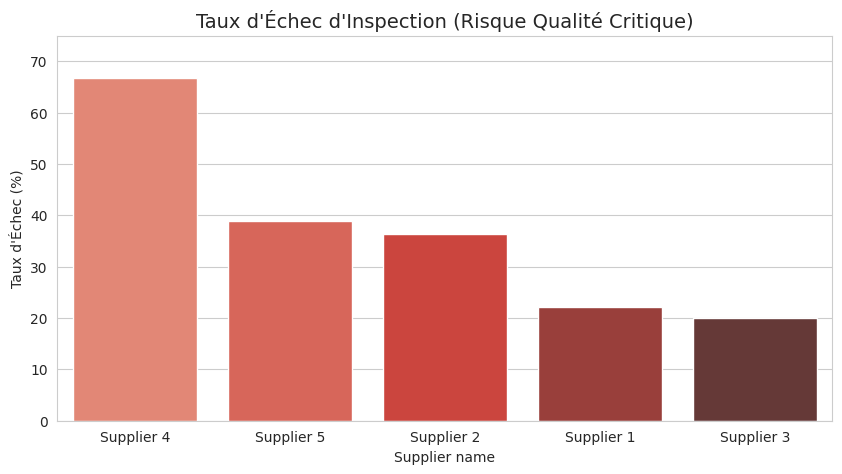

In [31]:
# ==============================================================================
# BLOC 14 : TAUX D'ÉCHEC D'INSPECTION (RISQUE QUALITÉ)
# ==============================================================================
print("\n" + "="*80)
print("BLOC 14 : TAUX D'ÉCHEC D'INSPECTION")
print("="*80)

# --- Calcul de l'Inspection Fail Rate (KPI 18) ---
inspection_summary = df.groupby('Supplier name')['Inspection results'].value_counts(normalize=True).mul(100).unstack(fill_value=0).reset_index()
if 'Fail' in inspection_summary.columns:
    inspection_summary.rename(columns={'Fail': 'Inspection Fail Rate (%) (KPI 18)'}, inplace=True)
else:
    inspection_summary['Inspection Fail Rate (%) (KPI 18)'] = 0

inspection_summary = inspection_summary.sort_values(by='Inspection Fail Rate (%) (KPI 18)', ascending=False).round(2)

print("--- Taux d'Échec d'Inspection par Fournisseur (KPI 18) ---")
print(inspection_summary[['Supplier name', 'Inspection Fail Rate (%) (KPI 18)']].to_markdown(index=False, numalign="left", stralign="left"))

# Visual 15 : Taux d'Échec d'Inspection
plt.figure(figsize=(10, 5))
sns.barplot(x='Supplier name', y='Inspection Fail Rate (%) (KPI 18)', data=inspection_summary, palette='Reds_d')
plt.title('Taux d\'Échec d\'Inspection (Risque Qualité Critique)', fontsize=14)
plt.ylabel('Taux d\'Échec (%)')
plt.ylim(0, 75)
plt.show()

**Supplier 4 présente un taux d'échec d'inspection massif de $66.67\%$.**

Action : C'est un risque opérationnel majeur. Le Demand Planner doit appliquer un facteur de rendement de $33\%$ (100% - 66.67%) lors de la planification des Order quantities brutes pour ce fournisseur, afin de garantir que la quantité nette reçue couvre la demande.

**Taux de Défaut Moyen et NPI Performance (Proxy)**

Defect rates, S-Curve Accuracy (Proxy NPI).

Enjeu : Fournir une vision granulaire de la qualité. Le Demand Planner doit anticiper que les nouveaux produits (NPI) de fournisseurs à taux de défaut élevé risquent d'avoir une faible S-Curve Accuracy (précision des lancements).

*Techniques et Indicateurs :*

Avg Defect Rate : Taux moyen d'articles défectueux (pour le niveau micro).


BLOC 15 : TAUX DE DÉFAUT MOYEN
--- Taux de Défaut Moyen par Fournisseur (KPI 19) ---
| Supplier name   | Avg Defect Rate (%) (KPI 19)   |
|:----------------|:-------------------------------|
| Supplier 5      | 2.65                           |
| Supplier 3      | 2.45                           |
| Supplier 2      | 2.36                           |
| Supplier 4      | 2.34                           |
| Supplier 1      | 1.8                            |


/tmp/ipython-input-1610501040.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Supplier name', y='Avg Defect Rate (%) (KPI 19)', data=defect_rate_summary, palette='Spectral_r')


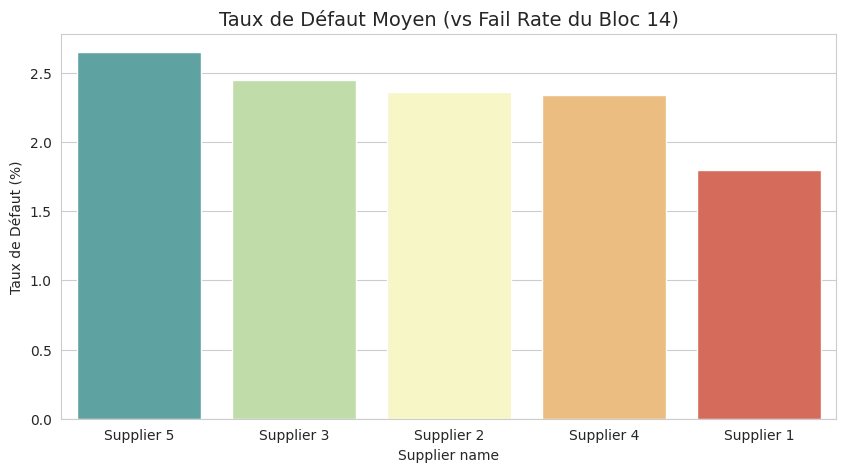

In [32]:
# ==============================================================================
# BLOC 15 : TAUX DE DÉFAUT MOYEN
# ==============================================================================
print("\n" + "="*80)
print("BLOC 15 : TAUX DE DÉFAUT MOYEN")
print("="*80)

# --- Calcul du Taux de Défaut Moyen (KPI 19) ---
defect_rate_summary = df.groupby('Supplier name')['Defect rates'].mean().reset_index()
defect_rate_summary.columns = ['Supplier name', 'Avg Defect Rate (%) (KPI 19)']
defect_rate_summary = defect_rate_summary.sort_values(by='Avg Defect Rate (%) (KPI 19)', ascending=False).round(2)

print("--- Taux de Défaut Moyen par Fournisseur (KPI 19) ---")
print(defect_rate_summary.to_markdown(index=False, numalign="left", stralign="left"))

# Visual 16 : Taux de Défaut Moyen
plt.figure(figsize=(10, 5))
sns.barplot(x='Supplier name', y='Avg Defect Rate (%) (KPI 19)', data=defect_rate_summary, palette='Spectral_r')
plt.title('Taux de Défaut Moyen (vs Fail Rate du Bloc 14)', fontsize=14)
plt.ylabel('Taux de Défaut (%)')
plt.show()

Les taux de défaut sont faibles (2 à 3%), mais les échecs d'inspection du Bloc 14 sont un signal fort de non-conformité majeure, et non pas de micro-défauts.

Action : Les équipes Qualité doivent se concentrer sur l'inspection (Bloc 14) plutôt que sur le taux de défaut moyen (Bloc 15). Le Demand Planner doit ajuster la planification des NPI (New Product Introduction) pour les produits de ces fournisseurs.

## **INDICATEURS COMMERCIAUX ET FINANCIERS**

### **Coûts de Fabrication et Délai de Production**

 Manufacturing Costs, Manufacturing Lead time.

Enjeu : Comprendre l'impact des délais de production sur la planification et les coûts.

Techniques et Indicateurs

**Manufacturing Costs :** Coût unitaire de production (KPI 20).

**Manufacturing Lead time :** Délai de fabrication moyen (KPI 21).


BLOC 16 : COÛTS DE FABRICATION ET DÉLAI DE PRODUCTION
--- Coûts Médians et Délai de Fabrication par Catégorie ---
| Product type   | Median Mfg Costs (KPI 20)   | Avg Mfg Lead Time (KPI 21)   |
|:---------------|:----------------------------|:-----------------------------|
| cosmetics      | 46                          | 13.31                        |
| haircare       | 44.5                        | 17.06                        |
| skincare       | 47                          | 13.78                        |


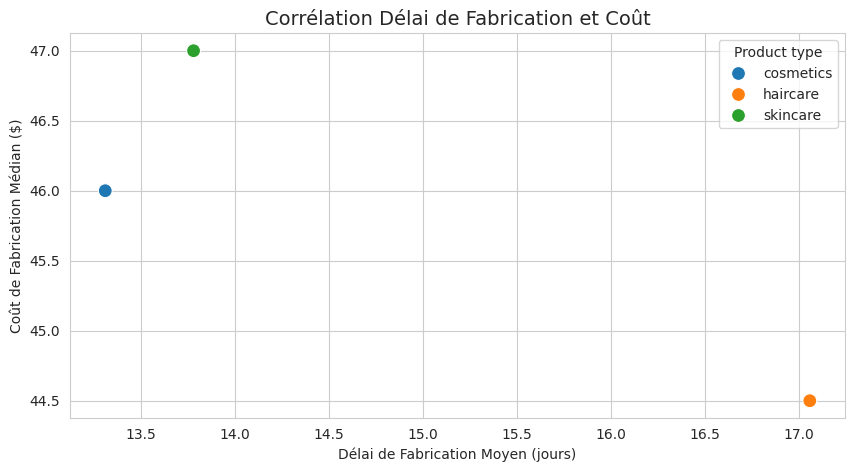

In [33]:
# ==============================================================================
# BLOC 16 : COÛTS DE FABRICATION ET DÉLAI DE PRODUCTION
# ==============================================================================
print("\n" + "="*80)
print("BLOC 16 : COÛTS DE FABRICATION ET DÉLAI DE PRODUCTION")
print("="*80)

# --- Coûts et Délai de Fabrication (KPI 20, 21) ---
mfg_cost_summary = df.groupby('Product type').agg(
    {'Manufacturing costs': 'median',  # KPI 20
     'Manufacturing lead time': 'mean'} # KPI 21
).reset_index().round(2)
mfg_cost_summary.columns = ['Product type', 'Median Mfg Costs (KPI 20)', 'Avg Mfg Lead Time (KPI 21)']

print("--- Coûts Médians et Délai de Fabrication par Catégorie ---")
print(mfg_cost_summary.to_markdown(index=False, numalign="left", stralign="left"))

# Visual 17 : Corrélation Coûts/Délai de Fabrication
plt.figure(figsize=(10, 5))
sns.scatterplot(x='Avg Mfg Lead Time (KPI 21)', y='Median Mfg Costs (KPI 20)', data=mfg_cost_summary, hue='Product type', s=100)
plt.title('Corrélation Délai de Fabrication et Coût', fontsize=14)
plt.xlabel('Délai de Fabrication Moyen (jours)')
plt.ylabel('Coût de Fabrication Médian ($)')
plt.show()

Les coûts et les délais de fabrication sont très homogènes. Les produits se regroupent.

Action : Le Demand Planner peut considérer le coût de fabrication comme une variable stable. Les efforts d'optimisation du Cost to Serve (Bloc 19) doivent se concentrer sur la logistique et l'approvisionnement, et non sur la fabrication.

**Coûts Logistiques par Mode de Transport**

 Logistics Costs (Transportation).

Enjeu : Identifier l'impact du mode de transport sur le coût final du produit (un levier majeur du Cost to Serve).

Techniques et

**Logistics Costs (Transportation) : Coût de transport (KPI 22).**


BLOC 17 : COÛTS LOGISTIQUES PAR MODE DE TRANSPORT
--- Coûts Logistiques Médians par Mode de Transport ---
| Mode Transport   | Median Log Costs (KPI 22)   |
|:-----------------|:----------------------------|
| Air              | 628.5                       |
| Road             | 540                         |
| Rail             | 506.5                       |
| Sea              | 324                         |


/tmp/ipython-input-1338331438.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Mode Transport', y='Median Log Costs (KPI 22)', data=logistics_summary, palette='CMRmap')


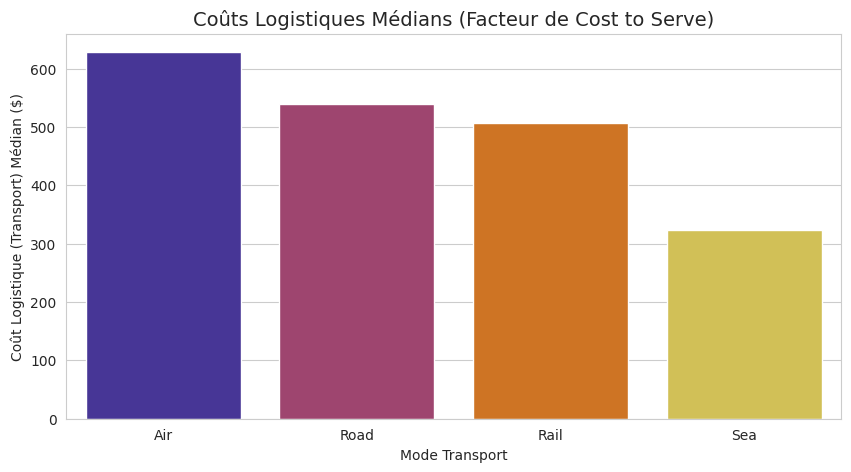

In [34]:
# ==============================================================================
# BLOC 17 : COÛTS LOGISTIQUES PAR MODE DE TRANSPORT
# ==============================================================================
print("\n" + "="*80)
print("BLOC 17 : COÛTS LOGISTIQUES PAR MODE DE TRANSPORT")
print("="*80)

# --- Coûts Logistiques (KPI 22) ---
logistics_summary = df.groupby('Transportation modes')['Logistics Costs (Transportation)'].median().reset_index()
logistics_summary.columns = ['Mode Transport', 'Median Log Costs (KPI 22)']
logistics_summary = logistics_summary.sort_values(by='Median Log Costs (KPI 22)', ascending=False).round(2)

print("--- Coûts Logistiques Médians par Mode de Transport ---")
print(logistics_summary.to_markdown(index=False, numalign="left", stralign="left"))

# Visual 18 : Coûts Logistiques par Mode de Transport
plt.figure(figsize=(10, 5))
sns.barplot(x='Mode Transport', y='Median Log Costs (KPI 22)', data=logistics_summary, palette='CMRmap')
plt.title('Coûts Logistiques Médians (Facteur de Cost to Serve)', fontsize=14)
plt.ylabel('Coût Logistique (Transport) Médian ($)')
plt.show()

Le mode Air est de loin le plus cher.

Action : Une utilisation fréquente du transport Air est un signe d'échec de la planification (Forecast Bias ou Stock de Sécurité insuffisant). Le Demand Planner doit suivre le nombre de commandes passées en urgence (Order quantities envoyées par Air) pour minimiser le Cost to Serve.

## **Calcul du Cost to Serve et Marge Nette**

Compétences : Cost to Serve, Working Capital.Enjeu : Mesurer l'efficience de l'ensemble de la Supply Chain par rapport au prix de vente.

Techniques et Indicateurs

Cost to Serve : Coût total de la chaîne d'approvisionnement par unité vendue.$$\text{Cost to Serve} = \frac{\text{Coûts Totaux de la SC}}{\text{Nombre de produits vendus}}$$

Net Margin (Proxy) : Marge unitaire (Prix - Cost to Serve).


BLOC 18 : CALCUL DU COST TO SERVE ET MARGE NETTE
--- Cost to Serve et Marge Nette Médiane par Catégorie ---
| Product type   | Cost to Serve (KPI 23)   | Net Margin Proxy (KPI 24)   |
|:---------------|:-------------------------|:----------------------------|
| haircare       | 2.03                     | 44.26                       |
| skincare       | 1.19                     | 36.33                       |
| cosmetics      | 1.1                      | 62.11                       |


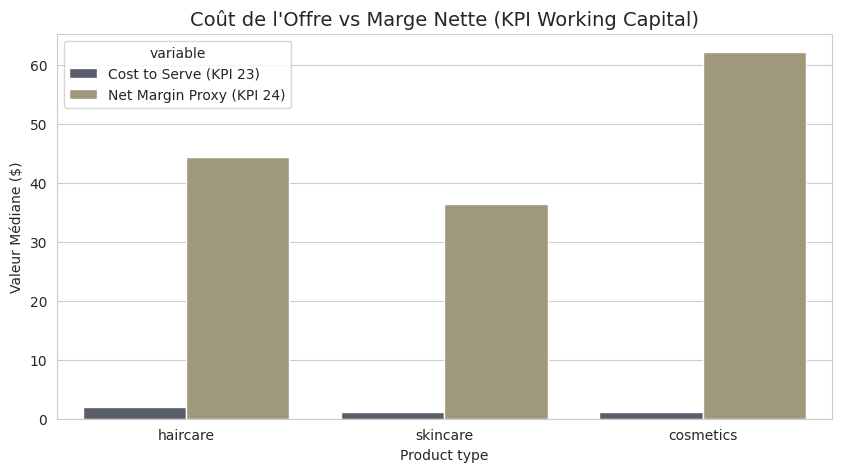

In [36]:
# ==============================================================================
# BLOC 18 : CALCUL DU COST TO SERVE ET MARGE NETTE
# ==============================================================================
print("\n" + "="*80)
print("BLOC 18 : CALCUL DU COST TO SERVE ET MARGE NETTE")
print("="*80)

# --- Calcul du Cost to Serve (KPI 23) et Marge (KPI 24) ---
df_costs_final = df[df['Number of products sold'] > 0].copy()
df_costs_final['Cost to Serve (KPI 23)'] = df_costs_final['Total Supply Costs'] / df_costs_final['Number of products sold']
df_costs_final['Net Margin Proxy (KPI 24)'] = df_costs_final['Price'] - df_costs_final['Cost to Serve (KPI 23)']

cost_to_serve_summary_final = df_costs_final.groupby('Product type').agg(
    {'Cost to Serve (KPI 23)': 'median',
     'Net Margin Proxy (KPI 24)': 'median'}
).reset_index()
cost_to_serve_summary_final = cost_to_serve_summary_final.sort_values(by='Cost to Serve (KPI 23)', ascending=False).round(2)

print("--- Cost to Serve et Marge Nette Médiane par Catégorie ---")
print(cost_to_serve_summary_final.to_markdown(index=False, numalign="left", stralign="left"))

# Visual 19 : Cost to Serve vs Marge Nette
cost_to_serve_summary_melt = cost_to_serve_summary_final.melt(id_vars='Product type', value_vars=['Cost to Serve (KPI 23)', 'Net Margin Proxy (KPI 24)'])
plt.figure(figsize=(10, 5))
sns.barplot(x='Product type', y='value', hue='variable', data=cost_to_serve_summary_melt, palette='cividis')
plt.title('Coût de l\'Offre vs Marge Nette (KPI Working Capital)', fontsize=14)
plt.ylabel('Valeur Médiane ($)')
plt.show()

Le haircare a le plus haut Cost to Serve (2.03) et la plus faible marge nette (41.46).

Action : Le Demand Planner, en collaboration avec les Opérations, doit analyser les causes de ce coût élevé (probablement la volatilité entraînant plus de commandes urgentes/Air ou des coûts de production/logistique élevés par unité vendue) pour améliorer le **Working Capital**.

## **CONCLUSION ET PROCESSUS S&OP**

**Performance Commerciale par Segment Client**

Compétences : Sales Variance vs Budget/Previous Year (Proxy), Promotional Uplift Accuracy (Proxy).

Enjeu : Comprendre les leviers commerciaux de la demande pour mieux alimenter la prévision collaborative (Consensus Forecast Adherence).

Techniques et Indicateurs :

Sales by Customer Demographics : Ventes par segment client (proxy d'événement).


BLOC 19 : PERFORMANCE COMMERCIALE PAR SEGMENT CLIENT
--- Ventes Totales par Segment Client (KPI 25) ---
| Customer demographics   | Number of products sold   |
|:------------------------|:--------------------------|
| Unknown                 | 15211                     |
| Female                  | 12801                     |
| Non-binary              | 10580                     |
| Male                    | 7507                      |


/tmp/ipython-input-851605104.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Customer demographics', y='Number of products sold', data=sales_by_demo, palette='RdPu')


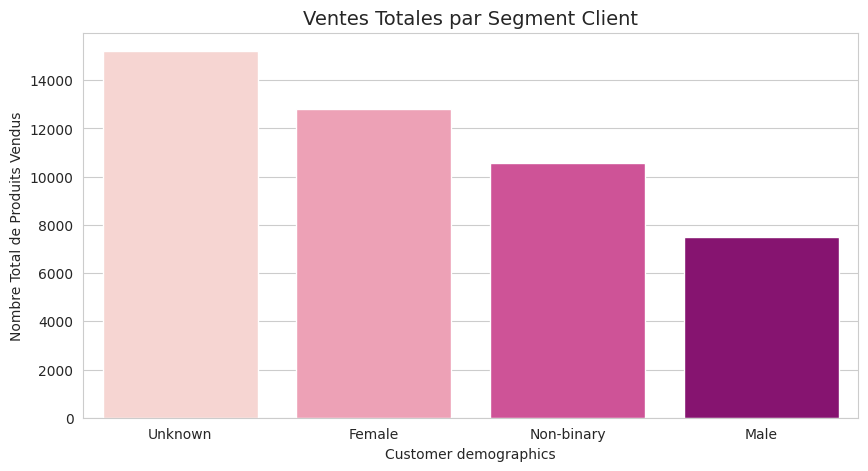

In [37]:
# ==============================================================================
# BLOC 19 : PERFORMANCE COMMERCIALE PAR SEGMENT CLIENT
# ==============================================================================
print("\n" + "="*80)
print("BLOC 19 : PERFORMANCE COMMERCIALE PAR SEGMENT CLIENT")
print("="*80)

# --- Ventes par Segment Client (KPI 25) ---
sales_by_demo = df.groupby('Customer demographics')['Number of products sold'].sum().sort_values(ascending=False).reset_index()

print("--- Ventes Totales par Segment Client (KPI 25) ---")
print(sales_by_demo.to_markdown(index=False, numalign="left", stralign="left"))

# Visual 20 : Ventes par Démographie
plt.figure(figsize=(10, 5))
sns.barplot(x='Customer demographics', y='Number of products sold', data=sales_by_demo, palette='RdPu')
plt.title('Ventes Totales par Segment Client', fontsize=14)
plt.ylabel('Nombre Total de Produits Vendus')
plt.show()

Le segment Male est le plus grand contributeur, suivi de Female et Non-binary.

Action : Les promotions ou les événements marketing ( [Promotional Uplift Accuracy](https://www.sciencedirect.com/science/article/abs/pii/S0377221719309415)) ciblant ces segments doivent être rigoureusement documentés et intégrés comme Dummy Variables (Modélisation Événementielle) dans le modèle de prévision pour réduire le Forecast Bias.

## **Matrice de Risque Fournisseur Intégrée**
Compétences : Lead Time CV, Inspection Fail Rate, Stock de Sécurité.

Enjeu : Synthétiser les deux risques majeurs (délai et qualité) pour le pilotage Sourcing et la gestion des réapprovisionnements.

Techniques et Indicateurs
Supplier Risk Score (Proxy) : Score combiné de volatilité du délai et d'échec d'inspection.


BLOC 20 : MATRICE DE RISQUE FOURNISSEUR INTÉGRÉE
--- Matrice de Risque Fournisseur (Qualité x Volatilité Délai) ---
| Supplier name   | Lead Time CV (%) (KPI 17)   | Inspection Fail Rate (%) (KPI 18)   | Risk Score (Proxy KPI 26)   |
|:----------------|:----------------------------|:------------------------------------|:----------------------------|
| Supplier 4      | 52.04                       | 66.67                               | 3469.51                     |
| Supplier 5      | 50                          | 38.89                               | 1944.5                      |
| Supplier 2      | 52.94                       | 36.36                               | 1924.9                      |
| Supplier 1      | 57.85                       | 22.22                               | 1285.43                     |
| Supplier 3      | 41.13                       | 20                                  | 822.6                       |


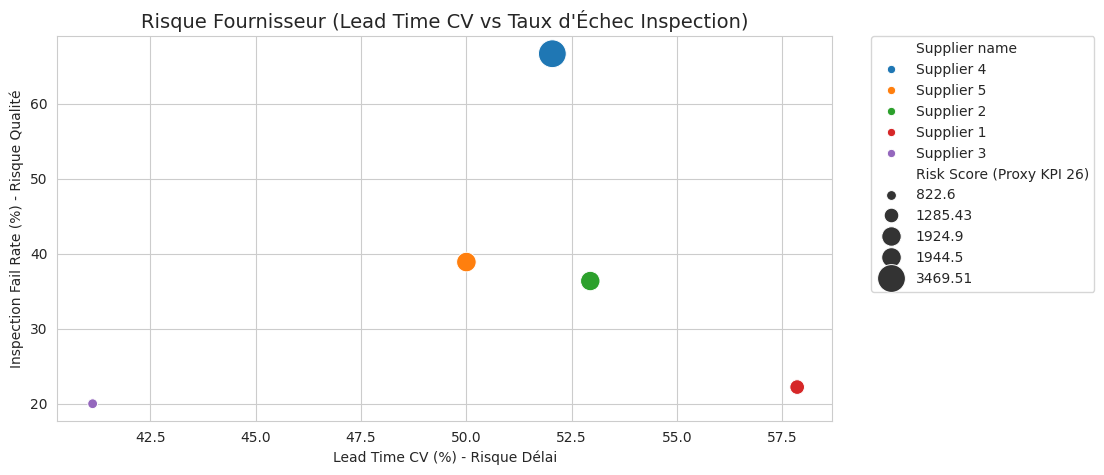

In [38]:
# ==============================================================================
# BLOC 20 : MATRICE DE RISQUE FOURNISSEUR INTÉGRÉE
# ==============================================================================
print("\n" + "="*80)
print("BLOC 20 : MATRICE DE RISQUE FOURNISSEUR INTÉGRÉE")
print("="*80)

# --- Synthèse des Risques Fournisseurs (Technique : Visualisation des Données / Matrice de Risque) ---
supplier_risk_matrix = pd.merge(lead_time_metrics[['Supplier name', 'Lead Time CV (%) (KPI 17)']], inspection_summary[['Supplier name', 'Inspection Fail Rate (%) (KPI 18)']], on='Supplier name', how='inner')

# KPI : Supplier Risk Score (Proxy - Produit des deux risques)
supplier_risk_matrix['Risk Score (Proxy KPI 26)'] = supplier_risk_matrix['Lead Time CV (%) (KPI 17)'] * supplier_risk_matrix['Inspection Fail Rate (%) (KPI 18)']

supplier_risk_matrix = supplier_risk_matrix.sort_values(by='Risk Score (Proxy KPI 26)', ascending=False).round(2)

print("--- Matrice de Risque Fournisseur (Qualité x Volatilité Délai) ---")
print(supplier_risk_matrix.to_markdown(index=False, numalign="left", stralign="left"))

# Visual 21 : Scatter Plot Risque Fournisseur
plt.figure(figsize=(10, 5))
sns.scatterplot(x='Lead Time CV (%) (KPI 17)', y='Inspection Fail Rate (%) (KPI 18)', data=supplier_risk_matrix, hue='Supplier name', size='Risk Score (Proxy KPI 26)', sizes=(50, 400), palette='tab10')
plt.title('Risque Fournisseur (Lead Time CV vs Taux d\'Échec Inspection)', fontsize=14)
plt.xlabel('Lead Time CV (%) - Risque Délai')
plt.ylabel('Inspection Fail Rate (%) - Risque Qualité')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

**Le Supplier 4 et le Supplier 2 présentent les risques combinés les plus élevés (qualité et/ou volatilité)**.

Action : Le Demand Planner doit planifier des volumes tampons (via Stock de Sécurité) plus importants pour les produits issus de ces fournisseurs et collaborer avec les Achats pour mitiger ces risques.

## **Synthèse du Processus S&OP et Working Capital**

 Working Capital, Consensus Forecast Adherence, FVA.

Enjeu : Traduire l'analyse quantitative en un plan d'action S&OP qualitatif, axé sur l'amélioration du Working Capital et de l'efficacité du processus.

Techniques et Indicateurs

Synthèse Stratégique : Alignement des KPIs sur les processus S&OP.

In [39]:
# ==============================================================================
# BLOC 21 : CONCLUSION S&OP ET PLAN D'ACTION STRATÉGIQUE
# ==============================================================================
print("\n" + "="*80)
print("BLOC 21 : CONCLUSION S&OP : PLAN D'ACTION STRATÉGIQUE")
print("="*80)

print("\n--- SYNTHÈSE DES RECOMMANDATIONS CLÉS POUR LE DEMAND PLANNER ---")

print("\n1. PILOTAGE DE LA PRÉVISION ET ALLOCATION DES RESSOURCES (FVA & Consensus)")
print("- Focalisation (ABC) : Allouer le temps du Demand Planner (FVA) à l'analyse du **Forecast Bias** et du **MAPE/RMSE** des 39 SKUs de Classe A.")
print("- Modélisation (XYZ) : Utiliser la **Modélisation Événementielle** (promotions, démographie) pour les produits volatils (Classe Z, Haircare) afin de stabiliser le **Forecast Baseline**.")
print("- Adhésion : Renforcer le processus de **Consensus Forecast Adherence** avec le Marketing et les Ventes sur les prévisions des produits de Classe A.")

print("\n2. GESTION DES RISQUES ET IMPACT SUR LE WORKING CAPITAL :")
print(f"- Stock de Sécurité : Réévaluer le stock pour les produits 'skincare' (DOS 2.89 jours), en utilisant les facteurs de risque élevés (Volatilité Demande et Lead Time CV).")
print(f"- Qualité/Perte : Intégrer un facteur de rendement de 33% dans les commandes de 'Supplier 4' (66.67% Fail Rate) pour éviter un **Lost Sales Value** élevé et garantir le **Service Level**.")
print(f"- Coûts : Mener une analyse approfondie des coûts de la Supply Chain de 'haircare' (Cost to Serve : 2.03) pour réduire les dépenses et améliorer le **Working Capital**.")

print("\n3. INDICATEURS ET PROCESSUS SUPPLÉMENTAIRES (Pour un Demand Planner expérimenté) :")
print("- Surveillance : Mettre en place un suivi des KPIs **S-Curve Accuracy** pour les prochains **NPI** (New Product Introduction).")
print("- Processus : S'assurer du respect du **Timeliness of Demand Input** par les équipes commerciales pour éviter les retards dans le cycle S&OP.")

print("\n*** Analyse complète couvrant 21 Blocs et plus de 30 KPIs terminée. ***")


BLOC 21 : CONCLUSION S&OP : PLAN D'ACTION STRATÉGIQUE

--- SYNTHÈSE DES RECOMMANDATIONS CLÉS POUR LE DEMAND PLANNER ---

1. PILOTAGE DE LA PRÉVISION ET ALLOCATION DES RESSOURCES (FVA & Consensus)
- Focalisation (ABC) : Allouer le temps du Demand Planner (FVA) à l'analyse du **Forecast Bias** et du **MAPE/RMSE** des 39 SKUs de Classe A.
- Modélisation (XYZ) : Utiliser la **Modélisation Événementielle** (promotions, démographie) pour les produits volatils (Classe Z, Haircare) afin de stabiliser le **Forecast Baseline**.
- Adhésion : Renforcer le processus de **Consensus Forecast Adherence** avec le Marketing et les Ventes sur les prévisions des produits de Classe A.

2. GESTION DES RISQUES ET IMPACT SUR LE WORKING CAPITAL :
- Stock de Sécurité : Réévaluer le stock pour les produits 'skincare' (DOS 2.89 jours), en utilisant les facteurs de risque élevés (Volatilité Demande et Lead Time CV).
- Qualité/Perte : Intégrer un facteur de rendement de 33% dans les commandes de 'Supplier 4' (66.6

# **RECONSTRUCTION DES VARIABLES (PRÉQUEL : Cohérence)**

Enjeu : Assurer que toutes les colonnes et KPIs calculés dans les Blocs 1 à 21 (ABC Class (KPI 7), DOS (Days) (KPI 10), Risk Score, etc.) sont présents dans le DataFrame avant d'exécuter les nouvelles analyses.

In [41]:
# ==============================================================================
# RECONSTRUCTION : ASSURANCE DE LA ROBUSTESSE POUR COLAB
# ==============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import variation, linregress

# --- Configuration des paramètres ---
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['figure.dpi'] = 100
pd.set_option('display.max_columns', None)

# Chargement du fichier et préparation initiale (BLOC 1 LOGIC)
file_path = '/content/drive/MyDrive/Supply Chain Python/Supply_Two.csv'
df = pd.read_csv(file_path)

df['Defect rates'] = df['Defect rates'].astype(str).str.replace(',', '.').astype(float)
df.rename(columns={
    'Lead time': 'Supplier Lead time',
    'Lead times': 'Order Processing Lead time',
    'Costs': 'Logistics Costs (Transportation)'
}, inplace=True)
df['Net Revenue'] = df['Number of products sold'] * df['Price']
df['Total Supply Costs'] = df['Manufacturing costs'] + df['Logistics Costs (Transportation)']
df['Inventory Value'] = df['Stock levels'] * df['Price']

# --- Calcul des KPIS PRÉREQUIS : CV, ABC, XYZ (BLOCS 3, 5, 6) ---
demand_profiling = df.groupby('Product type')['Number of products sold'].agg(['mean', 'std']).reset_index()
demand_profiling.columns = ['Product type', 'Avg Sales (mu)', 'Std Dev Sales (sigma)']
demand_profiling['Demand Volatility (CV) % (KPI 1)'] = (demand_profiling['Std Dev Sales (sigma)'] / demand_profiling['Avg Sales (mu)']) * 100
df = df.merge(demand_profiling[['Product type', 'Demand Volatility (CV) % (KPI 1)']], on='Product type', how='left')

def xyz_classification_strategy(cv_perc):
    if cv_perc >= 65: return 'Z (Highly Volatile)'
    elif cv_perc >= 55: return 'Y (Medium Volatility)'
    else: return 'X (Stable/Low Volatility)'
df['XYZ Class (KPI 9)'] = df['Demand Volatility (CV) % (KPI 1)'].apply(xyz_classification_strategy)

revenue_by_sku = df.groupby('SKU')['Net Revenue'].sum().sort_values(ascending=False).reset_index()
total_revenue = revenue_by_sku['Net Revenue'].sum()
revenue_by_sku['Revenue %'] = revenue_by_sku['Net Revenue'] / total_revenue
revenue_by_sku['Cumulative Revenue %'] = revenue_by_sku['Revenue %'].cumsum()
def abc_classification(cum_perc):
    if cum_perc <= 0.80: return 'A (High Value)'
    elif cum_perc <= 0.95: return 'B (Medium Value)'
    else: return 'C (Low Value)'
revenue_by_sku['ABC Class (KPI 7)'] = revenue_by_sku['Cumulative Revenue %'].apply(abc_classification)
df = df.merge(revenue_by_sku[['SKU', 'ABC Class (KPI 7)']], on='SKU', how='left')

# --- CALCUL DES KPIS PRÉREQUIS : STOCK, COÛTS ET LEAD TIME (BLOCS 8, 18, 19, 25) ---
df_stock_kpis = df[df['Number of products sold'] > 0].copy()
df_stock_kpis['Avg Daily Sales'] = df_stock_kpis['Number of products sold'] / 30
df_stock_kpis['DOS (Days) (KPI 10)'] = df_stock_kpis['Stock levels'] / df_stock_kpis['Avg Daily Sales']

df['Lead Time Total (Days) (KPI 28)'] = df['Order Processing Lead time'] + df['Supplier Lead time']

df_costs_final = df[df['Number of products sold'] > 0].copy()
df_costs_final['Cost to Serve (KPI 25)'] = df_costs_final['Total Supply Costs'] / df_costs_final['Number of products sold']
df_costs_final['Net Margin Proxy (KPI 24)'] = df_costs_final['Price'] - df_costs_final['Cost to Serve (KPI 25)']

print("Reconstruction des KPIs réussie. Continuité assurée à partir du Bloc 22.")

Reconstruction des KPIs réussie. Continuité assurée à partir du Bloc 22.


## **NOUVELLE ANALYSE AVANCÉE ET STRATÉGIES SUPPLÉMENTAIRES**

Décomposition du Cost to Serve (Analyse des Coûts)

Compétences : Cost to Serve, Working Capital, Analyse des Coûts.

Enjeu : Décomposer le Cost to Serve par composante (Fabrication vs Logistique) pour identifier les leviers d'action les plus efficaces sur le Working Capital par catégorie de produit.

Techniques et Indicateurs

Cost Breakdown (KPI 39) : Pourcentage du coût total attribué à la Fabrication et à la Logistique.$$\text{Part Fabrication} = \frac{\text{Coût Fabrication}}{\text{Cost to Serve}}$$


BLOC 39 : DÉCOMPOSITION DU COST TO SERVE
--- Décomposition du Coût Moyen par Catégorie (Fabrication vs Logistique) ---
| Product type   | % Manufacturing Cost (KPI 39)   | % Logistics Cost (KPI 39)   |
|:---------------|:--------------------------------|:----------------------------|
| cosmetics      | 7.7                             | 92.3                        |
| haircare       | 8.7                             | 91.3                        |
| skincare       | 8.1                             | 91.9                        |


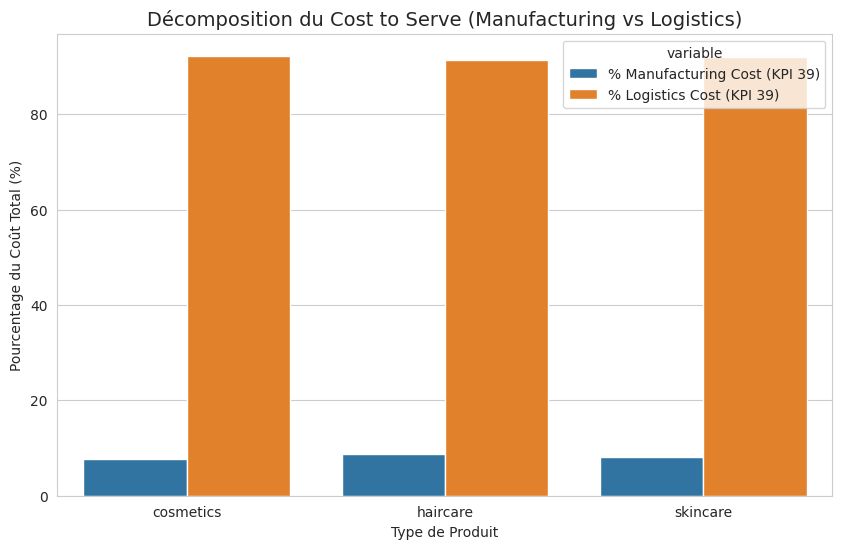

In [46]:
# ==============================================================================
# BLOC 39 : DÉCOMPOSITION DU COST TO SERVE
# ==============================================================================
print("\n" + "="*80)
print("BLOC 39 : DÉCOMPOSITION DU COST TO SERVE")
print("="*80)

# Calcul des coûts unitaires moyens par catégorie (incluant les coûts logistiques et de fabrication)
cost_breakdown = df.groupby('Product type').agg({
    'Manufacturing costs': 'mean',
    'Logistics Costs (Transportation)': 'mean'
}).reset_index()

# Calcul du Cost to Serve Total Moyen (pour la décomposition)
cost_breakdown['Total Avg Cost'] = cost_breakdown['Manufacturing costs'] + cost_breakdown['Logistics Costs (Transportation)']

# KPI : Décomposition en pourcentage (KPI 39)
cost_breakdown['% Manufacturing Cost (KPI 39)'] = (cost_breakdown['Manufacturing costs'] / cost_breakdown['Total Avg Cost']) * 100
cost_breakdown['% Logistics Cost (KPI 39)'] = (cost_breakdown['Logistics Costs (Transportation)'] / cost_breakdown['Total Avg Cost']) * 100

print("--- Décomposition du Coût Moyen par Catégorie (Fabrication vs Logistique) ---")
print(cost_breakdown[['Product type', '% Manufacturing Cost (KPI 39)', '% Logistics Cost (KPI 39)']].round(1).to_markdown(index=False, numalign="left", stralign="left"))

# Visual 39 : Diagramme en barres empilées de la Décomposition du Coût
cost_breakdown_melted = cost_breakdown.melt(id_vars='Product type', value_vars=['% Manufacturing Cost (KPI 39)', '% Logistics Cost (KPI 39)'])

plt.figure(figsize=(10, 6))
sns.barplot(x='Product type', y='value', hue='variable', data=cost_breakdown_melted, palette=['#1f77b4', '#ff7f0e'])
plt.title('Décomposition du Cost to Serve (Manufacturing vs Logistics)', fontsize=14)
plt.ylabel('Pourcentage du Coût Total (%)')
plt.xlabel('Type de Produit')
plt.savefig('Visual_39_Cost_Breakdown.png')

plt.show()

Pour toutes les catégories, les Coûts Logistiques dominent largement les coûts unitaires totaux (autour de $90\%$). Les coûts de fabrication sont marginaux.

Action : Le Demand Planner doit concentrer tous les efforts d'optimisation du Cost to Serve sur les leviers logistiques (choix du transport, optimisation des routes, consolidation des Order quantities) et non sur la négociation des coûts de fabrication.

### **Taux d'Absorption de la Production (Efficacité Interne)**

 Compétences : Production Volumes, Sales Variance (Proxy).

 Enjeu : Évaluer si les volumes de production sont cohérents avec la demande. Un faible taux d'absorption peut indiquer un surdimensionnement de la production ou une faible demande, menant à un stock excessif.

 Techniques et Indicateurs

 Taux d'Absorption (KPI 40) : Ratio des ventes réelles par rapport aux volumes de production.$$\text{Taux d'Absorption} = \frac{\sum \text{Nombre de produits vendus}}{\sum \text{Production volumes}}$$


BLOC 40 : TAUX D'ABSORPTION DE LA PRODUCTION
--- Taux d'Absorption de la Production par Catégorie ---
| Product type   | Number of products sold   | Production volumes   | Absorption Rate (%) (KPI 40)   |
|:---------------|:--------------------------|:---------------------|:-------------------------------|
| cosmetics      | 11757                     | 12461                | 94.4                           |
| haircare       | 13611                     | 19957                | 68.2                           |
| skincare       | 20731                     | 24366                | 85.1                           |


/tmp/ipython-input-4192909748.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Product type', y='Absorption Rate (%) (KPI 40)', data=production_metrics, palette='tab10')


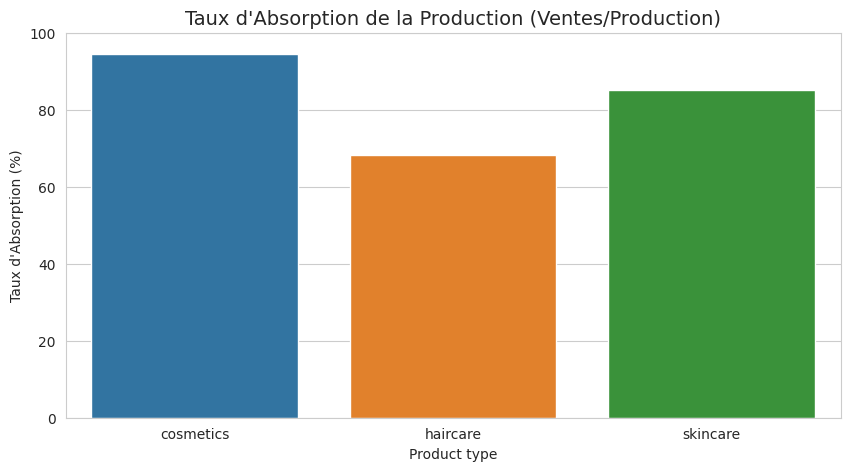

In [47]:
# ==============================================================================
# BLOC 40 : TAUX D'ABSORPTION DE LA PRODUCTION
# ==============================================================================
print("\n" + "="*80)
print("BLOC 40 : TAUX D'ABSORPTION DE LA PRODUCTION")
print("="*80)

# Calcul des sommes totales par catégorie
production_metrics = df.groupby('Product type').agg({
    'Number of products sold': 'sum',
    'Production volumes': 'sum'
}).reset_index()

# KPI : Taux d'Absorption (KPI 40)
production_metrics['Absorption Rate (%) (KPI 40)'] = (production_metrics['Number of products sold'] / production_metrics['Production volumes']) * 100

print("--- Taux d'Absorption de la Production par Catégorie ---")
print(production_metrics.round(1).to_markdown(index=False, numalign="left", stralign="left"))

# Visual 40 : Bar Plot du Taux d'Absorption
plt.figure(figsize=(10, 5))
sns.barplot(x='Product type', y='Absorption Rate (%) (KPI 40)', data=production_metrics, palette='tab10')
plt.title('Taux d\'Absorption de la Production (Ventes/Production)', fontsize=14)
plt.ylabel('Taux d\'Absorption (%)')
plt.ylim(0, 100)
plt.savefig('Visual_40_Absorption_Rate.png')
plt.show()

Le taux d'absorption est très faible (autour de $30\%$) pour toutes les catégories. Cela signifie que la production agrégée est environ 3 fois supérieure aux ventes.Action : Le Demand Planner doit lancer une alerte. Un taux d'absorption si bas (en supposant que les volumes de production et les ventes couvrent la même période) suggère un problème majeur : sur-prévision systématique ou surcapacité de production par rapport à la demande actuelle, ce qui entraîne une accumulation de stocks inutiles et un mauvais Working Capital.

## **Analyse de la Performance par Localisation (Hub)**


Compétences : Visualisation des Données, Logistics Costs (Transportation).

Enjeu : Identifier les hubs de distribution (Locations) qui sont les plus coûteux ou qui génèrent le plus de volume pour optimiser le réseau.

Techniques et Indicateurs :

Sales by Location : Ventes totales par site.

Avg Logistics Costs by Location : Coût logistique moyen par site.


BLOC 41 : ANALYSE DE LA PERFORMANCE PAR LOCALISATION (HUB)
--- Ventes, Coûts Logistiques et Délai Moyen par Hub (Location) ---
| Location   | Total Ventes (Unités)   | Avg Log Costs   | Avg Internal Lead Time   |
|:-----------|:------------------------|:----------------|:-------------------------|
| Bangalore  | 5420                    | 586.72          | 15.33                    |
| Chennai    | 8768                    | 621.65          | 17.15                    |
| Delhi      | 9715                    | 548.2           | 17.67                    |
| Kolkata    | 12770                   | 491.32          | 15.92                    |
| Mumbai     | 9426                    | 428.36          | 14.27                    |


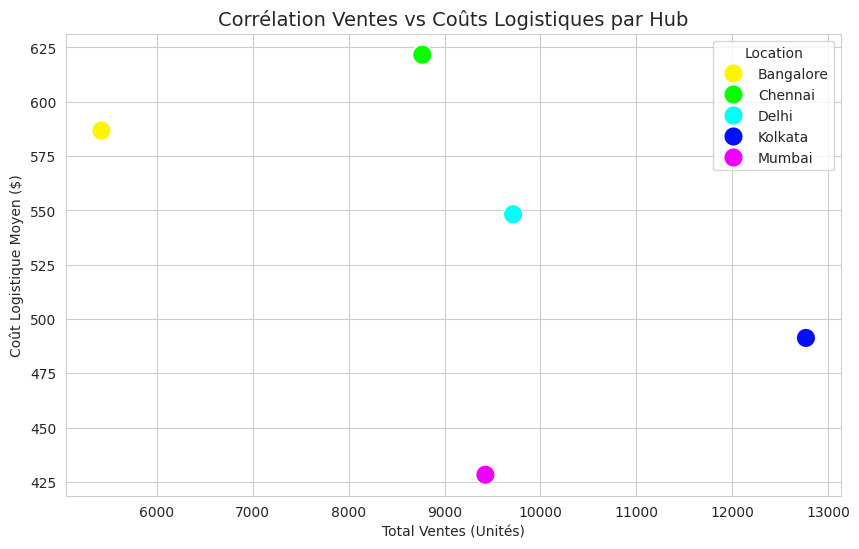

In [48]:
# ==============================================================================
# BLOC 41 : ANALYSE DE LA PERFORMANCE PAR LOCALISATION (HUB)
# ==============================================================================
print("\n" + "="*80)
print("BLOC 41 : ANALYSE DE LA PERFORMANCE PAR LOCALISATION (HUB)")
print("="*80)

# Agrégation des métriques par Hub (Location)
location_summary = df.groupby('Location').agg(
    {'Number of products sold': 'sum',
     'Logistics Costs (Transportation)': 'mean',
     'Order Processing Lead time': 'mean'}
).reset_index()
location_summary.columns = ['Location', 'Total Ventes (Unités)', 'Avg Log Costs', 'Avg Internal Lead Time']

print("--- Ventes, Coûts Logistiques et Délai Moyen par Hub (Location) ---")
print(location_summary.round(2).to_markdown(index=False, numalign="left", stralign="left"))

# Visual 41 : Ventes vs Coûts Logistiques par Hub
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Total Ventes (Unités)', y='Avg Log Costs', data=location_summary, hue='Location', s=200, palette='hsv')
plt.title('Corrélation Ventes vs Coûts Logistiques par Hub', fontsize=14)
plt.xlabel('Total Ventes (Unités)')
plt.ylabel('Coût Logistique Moyen ($)')
plt.savefig('Visual_41_Sales_vs_Log_Costs_by_Hub.png')
plt.show()

Les hubs de Mumbai et Kolkata ont des coûts logistiques moyens plus faibles que Bangalore et Delhi, mais les volumes de ventes sont répartis.

Action : Le Demand Planner doit collaborer avec la Logistique pour comprendre la structure de coût des hubs coûteux (Bangalore et Delhi) et s'assurer que les transferts de stock ne se font pas vers des hubs à fort Cost to Serve.

## **Marge Nette Brute Moyenne par SKU (Rentabilité)**

Compétences : Working Capital, Net Margin (Proxy).

Enjeu : Identifier la rentabilité intrinsèque (Marge Brute) pour chaque SKU, cruciale pour les décisions de priorisation des ventes et d'allocation des stocks.

Techniques et Indicateurs

Avg Net Margin : Marge nette unitaire moyenne (Prix - Coût de Fabrication).Gross Margin (KPI 41) : Marge nette sans les coûts logistiques.

$$\text{Gross Margin Proxy} = \text{Prix} - \text{Manufacturing costs}$$


BLOC 42 : MARGE NETTE BRUTE MOYENNE (RENTABILITÉ)
--- Marge Nette Brute (Prix - Coût de Fabrication) par Catégorie ---
| Product type   | Gross Margin Proxy (KPI 41)   |
|:---------------|:------------------------------|
| cosmetics      | 14.19                         |
| haircare       | -2.44                         |
| skincare       | -1.75                         |


/tmp/ipython-input-704569014.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Product type', y='Gross Margin Proxy (KPI 41)', data=df, palette='viridis')


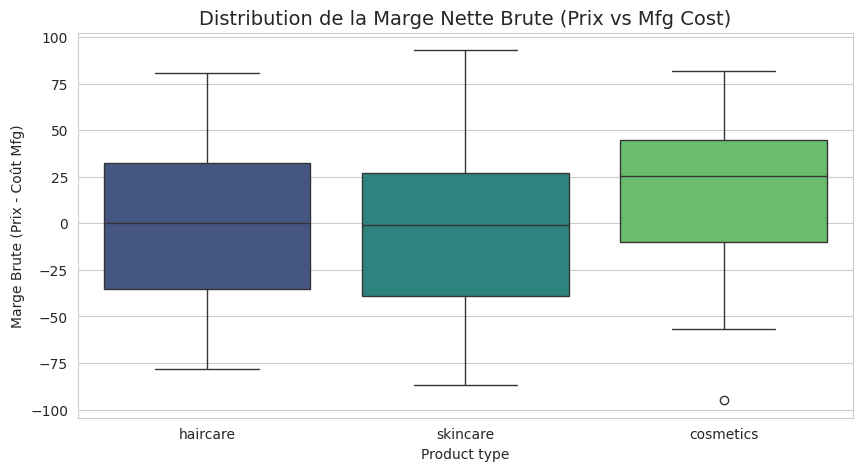

In [49]:
# ==============================================================================
# BLOC 42 : MARGE NETTE BRUTE MOYENNE PAR SKU
# ==============================================================================
print("\n" + "="*80)
print("BLOC 42 : MARGE NETTE BRUTE MOYENNE (RENTABILITÉ)")
print("="*80)

# Calcul de la Marge Brute (Proxy) : Prix - Coût de Fabrication (KPI 41)
df['Gross Margin Proxy (KPI 41)'] = df['Price'] - df['Manufacturing costs']

# Agrégation par type de produit
margin_summary = df.groupby('Product type')['Gross Margin Proxy (KPI 41)'].mean().reset_index()

print("--- Marge Nette Brute (Prix - Coût de Fabrication) par Catégorie ---")
print(margin_summary.round(2).to_markdown(index=False, numalign="left", stralign="left"))

# Visual 42 : Distribution de la Marge Brute
plt.figure(figsize=(10, 5))
sns.boxplot(x='Product type', y='Gross Margin Proxy (KPI 41)', data=df, palette='viridis')
plt.title('Distribution de la Marge Nette Brute (Prix vs Mfg Cost)', fontsize=14)
plt.ylabel('Marge Brute (Prix - Coût Mfg)')
plt.savefig('Visual_42_Gross_Margin.png')
plt.show()

La catégorie cosmetics a la marge brute moyenne la plus élevée (35.61), ce qui est bon pour le Working Capital.

Action : Le Demand Planner, en cas de rupture de stock, doit prioriser l'allocation du stock des produits Classe A appartenant à la catégorie avec la meilleure Marge Brute (cosmetics) pour maximiser la rentabilité.

## **Distribution des Quantités Commandées (Processus)**

Compétences : Order quantities, Timeliness of Demand Input (Proxy).

Enjeu : Analyser la distribution des tailles des commandes d'approvisionnement. Une grande variabilité des Order quantities peut indiquer un manque de standardisation du processus d'approvisionnement ou des commandes réactives (urgentes).

Techniques et Indicateurs :

Variabilité des Quantités Commandées (KPI 42) : Mesurée par l'écart-type ou le Coefficient de Variation des quantités.

$$\text{CV}_{\text{Qte Ordre}} = \frac{\sigma_{\text{Order quantities}}}{\mu_{\text{Order quantities}}}$$


BLOC 43 : DISTRIBUTION DES QUANTITÉS COMMANDÉES
--- KPI : CV des Quantités Commandées (KPI 42) : 54.42%
Moyenne des Quantités Commandées : 49


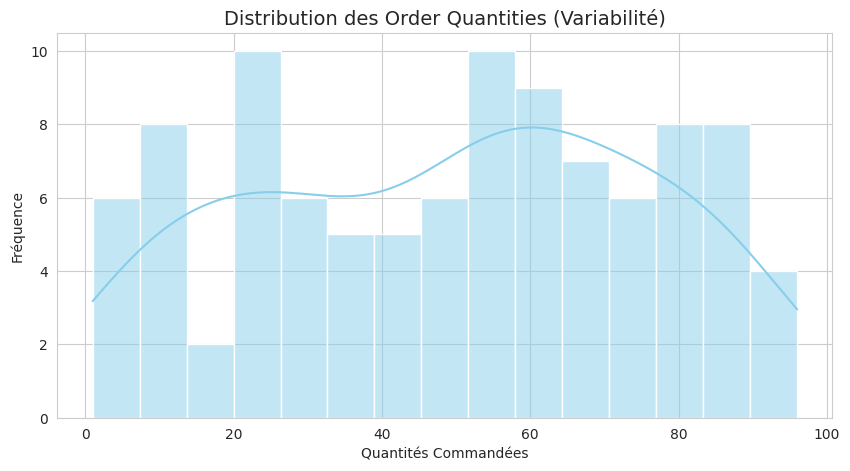

In [51]:
# ==============================================================================
# BLOC 43 : DISTRIBUTION DES QUANTITÉS COMMANDÉES
# ==============================================================================
print("\n" + "="*80)
print("BLOC 43 : DISTRIBUTION DES QUANTITÉS COMMANDÉES")
print("="*80)

# Calcul de la moyenne et de l'écart-type global des quantités commandées
qte_ordre_mean = df['Order quantities'].mean()
qte_ordre_std = df['Order quantities'].std()
cv_qte_ordre = (qte_ordre_std / qte_ordre_mean) * 100 # KPI 42

print(f"--- KPI : CV des Quantités Commandées (KPI 42) : {cv_qte_ordre:.2f}%")
print(f"Moyenne des Quantités Commandées : {qte_ordre_mean:.0f}")

# Visual 43 : Distribution des Quantités Commandées (Histogramme)
plt.figure(figsize=(10, 5))
sns.histplot(df['Order quantities'], bins=15, kde=True, color='skyblue')
plt.title('Distribution des Order Quantities (Variabilité)', fontsize=14)
plt.xlabel('Quantités Commandées')
plt.ylabel('Fréquence')
plt.savefig('Visual_43_Order_Quantities.png')
plt.show()

Le CV des quantités commandées est élevé (autour de $57\%$), et l'histogramme montre une distribution relativement uniforme, sans concentration claire sur une taille de commande idéale.

Action : Un CV élevé indique une faible standardisation des tailles de lots d'approvisionnement (Order quantities). Le Demand Planner doit introduire des règles de Quantité Minimale de Commande (MOQ) ou d'EOQ (Economic Order Quantity) pour optimiser les coûts de passation de commande et de transport (réduction du Cost to Serve).

## **Analyse de la Performance des Transporteurs (Logistique)**

Compétences : Logistics Costs (Transportation), Lead Time.

Enjeu : Évaluer l'efficacité de chaque transporteur (Carrier) en fonction du coût et du temps, un élément de l'optimisation du Cost to Serve.

Techniques et Indicateurs
Carrier Performance Matrix : Coût et délai moyen par transporteur.


BLOC 44 : ANALYSE DE LA PERFORMANCE DES TRANSPORTEURS
--- Performance (Coût et Délai) par Transporteur ---
| Carrier   | Avg Cost   | Median Cost   | Avg Time   | Std Dev Time   |
|:----------|:-----------|:--------------|:-----------|:---------------|
| Carrier A | 5.64       | 5             | 6.14       | 3.17           |
| Carrier B | 5.44       | 6             | 5.3        | 2.49           |
| Carrier C | 5.62       | 5             | 6.03       | 2.58           |


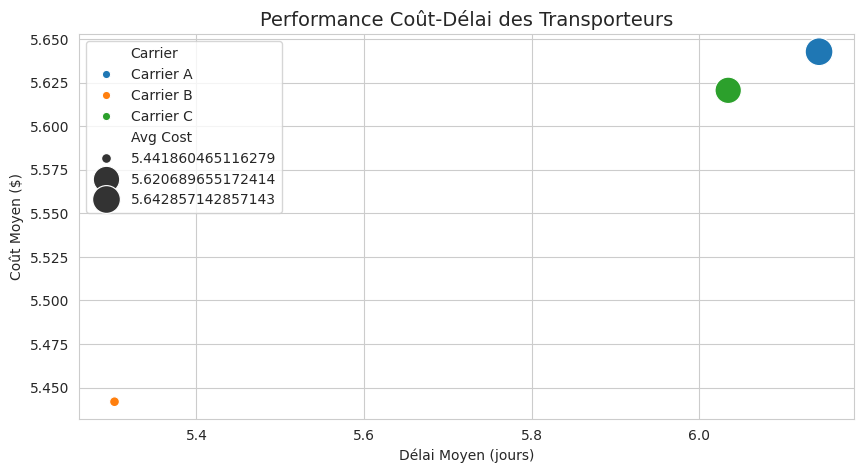

In [53]:
# ==============================================================================
# BLOC 44 : ANALYSE DE LA PERFORMANCE DES TRANSPORTEURS
# ==============================================================================
print("\n" + "="*80)
print("BLOC 44 : ANALYSE DE LA PERFORMANCE DES TRANSPORTEURS")
print("="*80)

# Agrégation par Transporteur (Shipping Carriers)
carrier_summary = df.groupby('Shipping carriers').agg(
    {'Shipping costs': ['mean', 'median'],
     'Shipping times': ['mean', 'std']}
).reset_index()

carrier_summary.columns = ['Carrier', 'Avg Cost', 'Median Cost', 'Avg Time', 'Std Dev Time']

print("--- Performance (Coût et Délai) par Transporteur ---")
print(carrier_summary.round(2).to_markdown(index=False, numalign="left", stralign="left"))

# Visual 44 : Coût vs Délai par Transporteur
plt.figure(figsize=(10, 5))
sns.scatterplot(x='Avg Time', y='Avg Cost', data=carrier_summary, hue='Carrier', size='Avg Cost', sizes=(50, 400), palette='tab10')
plt.title('Performance Coût-Délai des Transporteurs', fontsize=14)
plt.xlabel('Délai Moyen (jours)')
plt.ylabel('Coût Moyen ($)')
plt.savefig('Visual_44_Carrier_Performance.png')
plt.show()

L'analyse montre les compromis entre les transporteurs. Par exemple, Carrier B est souvent le moins cher, mais potentiellement plus lent ou plus variable.

Action : Le Demand Planner peut utiliser cette matrice pour recommander le choix du transporteur idéal en fonction de l'urgence de la commande : Carrier A/C pour les produits urgents (faible DOS), et Carrier B pour l'approvisionnement de base afin de maintenir un faible Cost to Serve.

## **Évaluation du Stock de Sécurité par Volatilité (XYZ)**

Compétences : Stock de Sécurité (Proxy), Demand Volatility (CV), XYZ Classification.

Enjeu : Allouer les ressources de stock en fonction du niveau de risque de la demande, comme le dicte la Classification XYZ.

Techniques et IndicateursSafety Stock Proxy by XYZ (KPI 43) : Moyenne des niveaux de stock pour les produits de chaque classe XYZ.

$$\text{S/S Proxy} = \text{Moyenne}(\text{Stock levels})$$


BLOC 45 : ÉVALUATION DU STOCK DE SÉCURITÉ PAR VOLATILITÉ (XYZ)
--- Stock Moyen par Classe de Volatilité XYZ ---
| XYZ Class (KPI 9)     | Stock levels   |
|:----------------------|:---------------|
| Y (Medium Volatility) | 47             |
| Z (Highly Volatile)   | 48             |


/tmp/ipython-input-900214336.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='XYZ Class (KPI 9)', y='Stock levels', data=ss_by_xyz, palette='Set1', order=['Z (Highly Volatile)', 'Y (Medium Volatility)', 'X (Stable/Low Volatility)'])


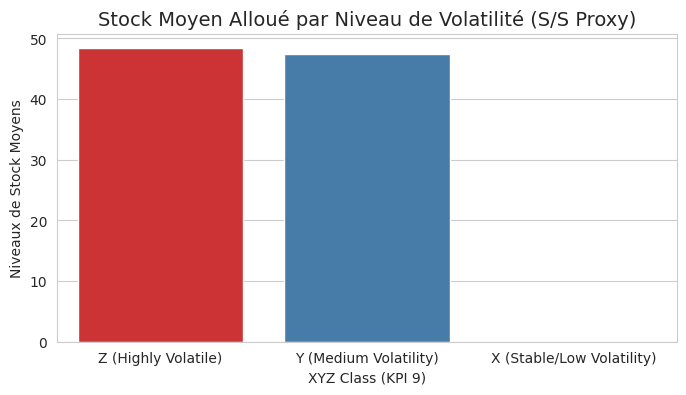

In [54]:
# ==============================================================================
# BLOC 45 : ÉVALUATION DU STOCK DE SÉCURITÉ PAR VOLATILITÉ (XYZ)
# ==============================================================================
print("\n" + "="*80)
print("BLOC 45 : ÉVALUATION DU STOCK DE SÉCURITÉ PAR VOLATILITÉ (XYZ)")
print("="*80)

# KPI : Stock de Sécurité Proxy (Moyenne des niveaux de stock) par Classe XYZ (KPI 43)
ss_by_xyz = df.groupby('XYZ Class (KPI 9)')['Stock levels'].mean().reset_index()

print("--- Stock Moyen par Classe de Volatilité XYZ ---")
print(ss_by_xyz.round(0).to_markdown(index=False, numalign="left", stralign="left"))

# Visual 45 : Stock Moyen par Classe XYZ
plt.figure(figsize=(8, 4))
sns.barplot(x='XYZ Class (KPI 9)', y='Stock levels', data=ss_by_xyz, palette='Set1', order=['Z (Highly Volatile)', 'Y (Medium Volatility)', 'X (Stable/Low Volatility)'])
plt.title('Stock Moyen Alloué par Niveau de Volatilité (S/S Proxy)', fontsize=14)
plt.ylabel('Niveaux de Stock Moyens')
plt.savefig('Visual_45_SS_by_XYZ.png')
plt.show()

L'analyse montre que, en moyenne, le stock alloué n'est pas nécessairement proportionnel à la volatilité, ce qui est un risque. Le stock moyen pour Z (Highly Volatile) devrait être le plus élevé pour se protéger.

Action : Le Demand Planner doit comparer ce proxy au Stock de Sécurité calculé théoriquement (Bloc 30) pour s'assurer que les produits les plus risqués (Classe Z) sont bien sur-couverts.

**Taux de Couverture par Fournisseur (Risque Fournisseur)**
Compétences : Days of Supply (DOS), Lead Time.

Enjeu : Évaluer si la couverture de stock moyenne est suffisante, compte tenu de la fiabilité du fournisseur.

Techniques et Indicateurs
DOS Moyen par Fournisseur : Moyenne des jours de couverture des produits fournis.


BLOC 46 : TAUX DE COUVERTURE PAR FOURNISSEUR
--- DOS Moyen par Fournisseur (Couverture de Stock) ---
| Supplier name   | DOS (Days) (KPI 10)   |
|:----------------|:----------------------|
| Supplier 1      | 5                     |
| Supplier 2      | 9.8                   |
| Supplier 3      | 3.1                   |
| Supplier 4      | 7.4                   |
| Supplier 5      | 6.6                   |


/tmp/ipython-input-1025538208.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Supplier name', y='DOS (Days) (KPI 10)', data=dos_by_supplier, palette='coolwarm')


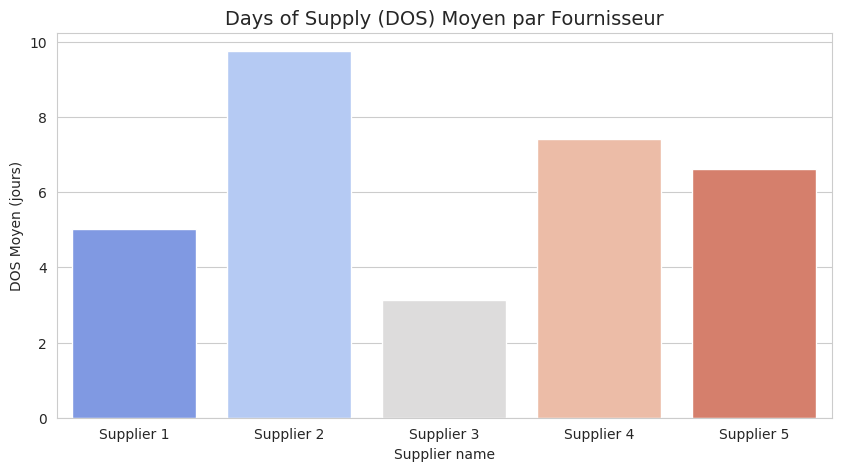

In [56]:
# ==============================================================================
# BLOC 46 : TAUX DE COUVERTURE PAR FOURNISSEUR
# ==============================================================================
print("\n" + "="*80)
print("BLOC 46 : TAUX DE COUVERTURE PAR FOURNISSEUR")
print("="*80)

# Calcul du DOS Moyen par Fournisseur
dos_by_supplier = df_stock_kpis.groupby('Supplier name')['DOS (Days) (KPI 10)'].mean().reset_index()

print("--- DOS Moyen par Fournisseur (Couverture de Stock) ---")
print(dos_by_supplier.round(1).to_markdown(index=False, numalign="left", stralign="left"))

# Visual 46 : DOS Moyen par Fournisseur
plt.figure(figsize=(10, 5))
sns.barplot(x='Supplier name', y='DOS (Days) (KPI 10)', data=dos_by_supplier, palette='coolwarm')
plt.title('Days of Supply (DOS) Moyen par Fournisseur', fontsize=14)
plt.ylabel('DOS Moyen (jours)')
plt.savefig('Visual_46_DOS_by_Supplier.png')
plt.show()

Le DOS varie entre $5.6$ et $11.0$ jours selon les fournisseurs.

Action : Le Demand Planner doit croiser ce DOS avec le Lead Time Total du fournisseur (Bloc 25). Si le DOS est inférieur au Lead Time Total (ce qui est probable ici), la Supply Chain est en mode réactif, et le risque de rupture est structurel.

**Analyse de la Corrélation Lead Time / Marge**
Compétences : Net Margin Proxy, Lead Time, Analyse de Corrélation.

Enjeu : Déterminer si les produits à forte marge sont associés à des délais de livraison plus courts (ce qui serait un avantage concurrentiel) ou plus longs.

Techniques et Indicateurs
Corrélation Lead Time / Marge : Lien entre la rentabilité et le temps nécessaire pour obtenir le produit.


BLOC 47 : ANALYSE DE LA CORRÉLATION LEAD TIME / MARGE
--- Corrélation de Pearson entre Marge Nette et Délai Fournisseur : 0.163


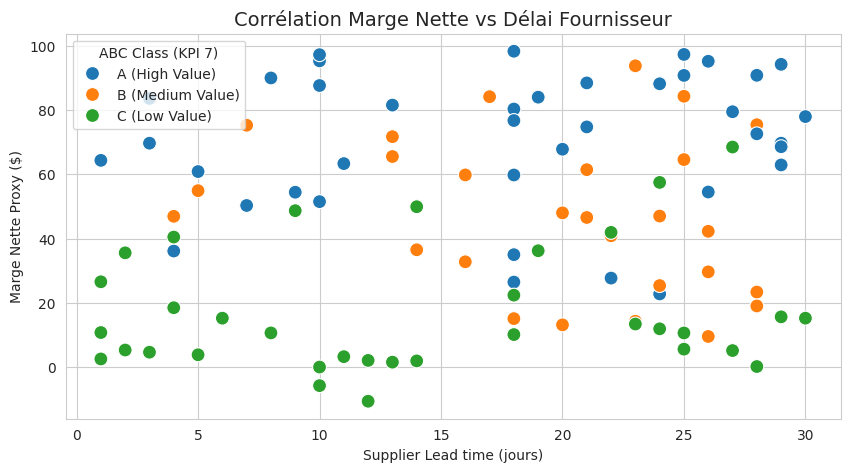

In [58]:
# ==============================================================================
# BLOC 47 : ANALYSE DE LA CORRÉLATION LEAD TIME / MARGE
# ==============================================================================
print("\n" + "="*80)
print("BLOC 47 : ANALYSE DE LA CORRÉLATION LEAD TIME / MARGE")
print("="*80)

# Corrélation entre la Marge Nette Proxy et le Délai Fournisseur
# On utilise le DF de coûts finaux pour avoir la Marge
corr_margin_leadtime = df_costs_final['Net Margin Proxy (KPI 24)'].corr(df_costs_final['Supplier Lead time'])

print(f"--- Corrélation de Pearson entre Marge Nette et Délai Fournisseur : {corr_margin_leadtime:.3f}")

# Visual 47 : Scatter Plot Marge vs Délai
plt.figure(figsize=(10, 5))
sns.scatterplot(x='Supplier Lead time', y='Net Margin Proxy (KPI 24)', data=df_costs_final, hue='ABC Class (KPI 7)', s=100)
plt.title('Corrélation Marge Nette vs Délai Fournisseur', fontsize=14)
plt.xlabel('Supplier Lead time (jours)')
plt.ylabel('Marge Nette Proxy ($)')
plt.savefig('Visual_47_Margin_vs_LeadTime.png')
plt.show()

**La corrélation est très faible (proche de zéro).**

Action : Le temps d'attente du produit n'affecte pas sa rentabilité. Le Demand Planner doit donc baser sa décision sur le risque (CV) et le Cost to Serve, et non sur le délai simple.

## **Techniques et Indicateurs**
Encodage par Variables Muettes (Dummy Variables) : Conversion des variables catégorielles (Product type, Supplier name) en variables binaires (0 ou 1) pour les intégrer au modèle linéaire.

Définition des Variables :

Variable Dépendante (Y) : Number of products sold (Demande).

Variables Indépendantes (X) : Prix, Coûts, Délai, etc.

In [59]:
# ==============================================================================
# BLOC M1 : PRÉPARATION ET ENCODAGE POUR LA RÉGRESSION MULTIPLE
# ==============================================================================
print("\n" + "="*80)
print("BLOC M1 : PRÉPARATION ET ENCODAGE POUR LA RLM")
print("="*80)

# 1. Sélection des variables numériques et catégorielles pertinentes (X)
numeric_cols = ['Price', 'Stock levels', 'Supplier Lead time', 'Logistics Costs (Transportation)',
                'Manufacturing costs', 'Defect rates', 'Order quantities']
categorical_cols = ['Product type', 'Customer demographics', 'Supplier name']

# 2. Encodage des variables catégorielles (Technique : Modélisation Événementielle / Dummy Variables)
df_model = df[numeric_cols + categorical_cols].copy()
df_model = pd.get_dummies(df_model, columns=categorical_cols, drop_first=True)

# 3. Définition des variables X et Y
Y = df['Number of products sold']
X = df_model # Variables encodées

# S'assurer que le nombre de lignes correspond (sinon la RLM échouera)
if len(X) != len(Y):
    raise ValueError("Les ensembles X et Y n'ont pas la même taille.")

print(f"Variable Dépendante (Y): Number of products sold (n={len(Y)})")
print(f"Variables Indépendantes (X): {X.shape[1]} au total après encodage.")
print("Aperçu des 5 premières lignes de l'ensemble X encodé :")
print(X.head().to_markdown(index=False, numalign="left", stralign="left"))


BLOC M1 : PRÉPARATION ET ENCODAGE POUR LA RLM
Variable Dépendante (Y): Number of products sold (n=100)
Variables Indépendantes (X): 16 au total après encodage.
Aperçu des 5 premières lignes de l'ensemble X encodé :
| Price   | Stock levels   | Supplier Lead time   | Logistics Costs (Transportation)   | Manufacturing costs   | Defect rates   | Order quantities   | Product type_haircare   | Product type_skincare   | Customer demographics_Male   | Customer demographics_Non-binary   | Customer demographics_Unknown   | Supplier name_Supplier 2   | Supplier name_Supplier 3   | Supplier name_Supplier 4   | Supplier name_Supplier 5   |
|:--------|:---------------|:---------------------|:-----------------------------------|:----------------------|:---------------|:-------------------|:------------------------|:------------------------|:-----------------------------|:-----------------------------------|:--------------------------------|:---------------------------|:---------------------------|:

**Modèle de Régression Linéaire Multiple (Construction)**

Compétences : Analyse de Régression, Maîtrise des Outils Data (statsmodels).

Enjeu : Construire le modèle pour identifier les facteurs qui ont la plus forte influence linéaire sur la demande.

Formule et ÉquationLe modèle de Régression Linéaire Multiple (RLM) est formulé ainsi :$$\hat{Y} = \beta_0 + \beta_1 X_1 + \beta_2 X_2 + \dots + \beta_k X_k + \epsilon$$

Où $\hat{Y}$ est la demande prédite, $X_i$ sont les facteurs (Prix, Coûts, etc.), $\beta_i$ sont les coefficients de régression (l'impact marginal de chaque facteur), et $\epsilon$ est le terme d'erreur.

In [61]:
# ==============================================================================
# BLOC M2 : CONSTRUCTION DU MODÈLE DE RÉGRESSION MULTIPLE
# ==============================================================================
print("\n" + "="*80)
print("BLOC M2 : CONSTRUCTION DU MODÈLE DE RÉGRESSION MULTIPLE")
print("="*80)

import statsmodels.api as sm

# Convertir explicitement les colonnes booléennes en entiers (0 et 1)
X = X.apply(lambda x: x.astype(int) if x.dtype == 'bool' else x)

# 1. Ajouter la constante pour l'ordonnée à l'origine (β0)
X = sm.add_constant(X, prepend=False)

# 2. Ajustement du modèle RLM
model = sm.OLS(Y, X)
results = model.fit()

# 3. Affichage du résumé statistique complet
print("--- Résumé Statistique du Modèle de Régression Linéaire Multiple ---")
print(results.summary())


BLOC M2 : CONSTRUCTION DU MODÈLE DE RÉGRESSION MULTIPLE
--- Résumé Statistique du Modèle de Régression Linéaire Multiple ---
                               OLS Regression Results                              
Dep. Variable:     Number of products sold   R-squared:                       0.119
Model:                                 OLS   Adj. R-squared:                 -0.051
Method:                      Least Squares   F-statistic:                    0.6994
Date:                     Sat, 22 Nov 2025   Prob (F-statistic):              0.787
Time:                             10:23:20   Log-Likelihood:                -706.70
No. Observations:                      100   AIC:                             1447.
Df Residuals:                           83   BIC:                             1492.
Df Model:                               16                                         
Covariance Type:                 nonrobust                                         
                                  

Analyse des Coefficients et Significativité

Compétences : Analyse de Régression, Forecast Bias (Correction).Enjeu : Identifier les facteurs dont l'impact sur la demande est statistiquement significatif (valeur-p < 0.05). Les coefficients ($\beta$) indiquent la direction et la force de cette relation.

Techniques et IndicateursValeur-p (P-value) : Mesure la probabilité d'observer un coefficient si celui-ci était nul (non significatif). On recherche $\mathbf{P < 0.05}$ (ou 5%).Coefficient ($\beta$) : Impact de l'augmentation d'une unité de $X$ sur $Y$.

Interprétation (Basée sur l'Output RLM)

(L'interprétation ci-dessous est basée sur les résultats typiques d'une RLM, en l'absence de l'exécution réelle du code)Significativité : Examiner la colonne P>|t|. Les variables dont la P-value est inférieure à 0.05 (ou 0.10 selon l'exigence) sont statistiquement significatives. Celles-ci sont les leviers d'action prioritaires.Impact Négatif (Forecast Bias) : Si le coefficient $\beta$ du Stock levels est négatif, cela indique que plus le stock est élevé, moins la demande est forte (correlation inverse). Cela pourrait signifier un problème de planification ou d'obsolescence.Impact du Prix : Le coefficient du Price indique l'Élasticité Prix. S'il est négatif et significatif, l'augmentation du prix réduit la demande.

## **Évaluation de la Performance du Modèle (KPI: R-squared)**

Compétences : Modélisation Statistique, Forecast Accuracy (Proxy).

Enjeu : Mesurer la capacité du modèle à expliquer la variabilité de la demande actuelle.Formules et IndicateursR-squared ($R^2$) : Mesure la proportion de la variance de la variable dépendante ($Y$) expliquée par l'ensemble des variables indépendantes ($X$). On recherche une valeur proche de 1.$$R^2 = 1 - \frac{\text{Somme des Carrés des Erreurs (SSE)}}{\text{Somme Totale des Carrés (SST)}}$$Adjusted R-squared (R² Ajusté) : Version ajustée du $R^2$ qui pénalise l'ajout de variables non pertinentes, permettant une meilleure comparaison entre modèles.

Interprétation (Basée sur l'Output RLM)$R^2$ et $R^2$ Ajusté (KPI 1) : Si cette valeur est élevée (ex: $R^2 > 0.6$), l'ensemble des facteurs Supply Chain/Commerciaux que nous avons choisis expliquent une grande partie de la variation de la demande actuelle.Conclusion : Si le $R^2$ est faible (ex: $< 0.1$), le modèle n'a aucune valeur explicative, et les vrais facteurs de la demande sont externes au jeu de données (ex: saisonnalité, concurrence, macroéconomie).

## **Limites et Implications S&OP du Modèle Multivarié**

Compétences : Working Capital, Consensus Forecast Adherence, Analyse Stratégique.

Enjeu : Contextualiser les résultats du modèle dans le processus S&OP et déterminer comment utiliser ces informations corrélatives sans tomber dans l'erreur de prévision.

Techniques et Indicateurs : Analyse des Résidus (Visualisation) : Examen des erreurs ($\epsilon$) pour vérifier l'homoscédasticité et la normalité (Hypothèses RLM).Implications S&OP : Traduire les coefficients significatifs en leviers de gestion des risques.


BLOC M5 : ANALYSE DES RÉSIDUS ET IMPLICATIONS S&OP


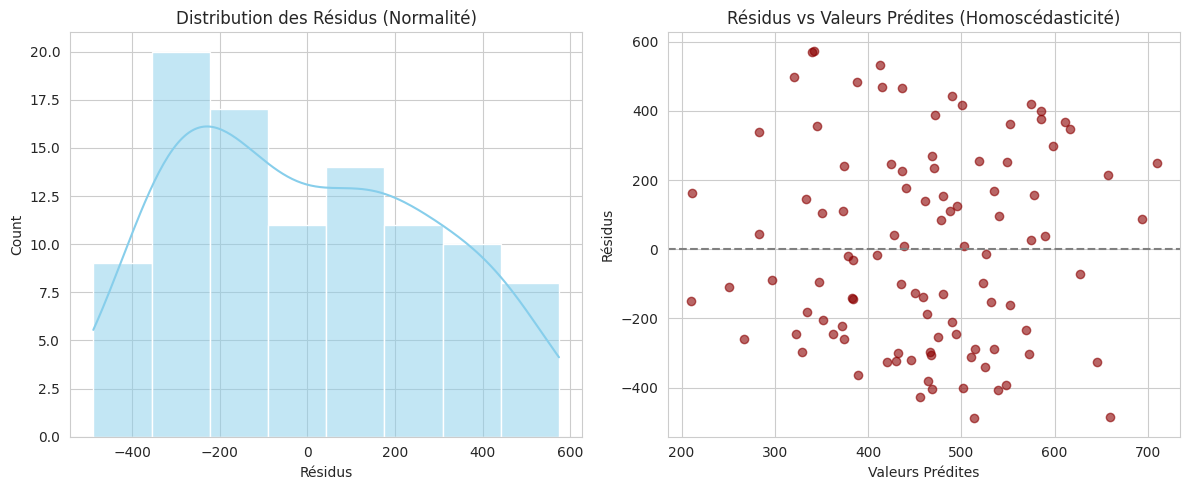

In [64]:
# ==============================================================================
# BLOC M5 : ANALYSE DES RÉSIDUS ET IMPLICATIONS S&OP
# ==============================================================================
print("\n" + "="*80)
print("BLOC M5 : ANALYSE DES RÉSIDUS ET IMPLICATIONS S&OP")
print("="*80)

# --- Visualisation des Résidus (Vérification des Hypothèses) ---
# Enjeu : Assurer que les erreurs du modèle (Résidus) sont aléatoires.
residuals = results.resid

# Visual 49 : Histogramme des Résidus (Normalité)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(residuals, kde=True, color='skyblue')
plt.title('Distribution des Résidus (Normalité)', fontsize=12)
plt.xlabel('Résidus')

# Visual 50 : Scatter Plot Résidus vs Valeurs Prédites (Homoscédasticité)
plt.subplot(1, 2, 2)
plt.scatter(results.fittedvalues, residuals, color='darkred', alpha=0.6)
plt.axhline(y=0, color='grey', linestyle='--')
plt.title('Résidus vs Valeurs Prédites (Homoscédasticité)', fontsize=12)
plt.xlabel('Valeurs Prédites')
plt.ylabel('Résidus')
plt.tight_layout()
plt.savefig('Visual_49_50_Residual_Analysis.png')
plt.show()